# Study Analysis: Hyperparameter Optimization Trade-offs

Analysis of Optuna hyperparameter optimization results focusing on training trade-offs and architectural insights.

In [41]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

In [42]:
# Load Optuna study data
import optuna
import dotenv
from optuna.storages import RDBStorage
from optuna.trial import TrialState

# Load environment variables
dotenv.load_dotenv()
SUPABASE_URL = dotenv.get_key('.env', 'SUPABASE_URL')

# Connect to study
storage = RDBStorage(url=SUPABASE_URL)
study = optuna.load_study(
    study_name='ZINC_GDL_Pipeline_Optimization_2',
    storage=storage
)

print(f"Loaded study with {len(study.trials)} trials")

Loaded study with 129 trials


In [57]:
# Create clean DataFrames
def load_study_data(study):
    trial_data = []
    
    for trial in study.trials:
        if trial.state != TrialState.COMPLETE or trial.values is None:
            continue
            
        row = {
            'trial_number': trial.number,
            'val_mae': trial.values[0],
            'total_parameters': trial.values[1] if len(trial.values) > 1 else None,
            'gnn_parameters': trial.values[2] if len(trial.values) > 2 else None,
            'pooling_parameters': trial.values[3] if len(trial.values) > 3 else None,
            'regressor_parameters': trial.values[4] if len(trial.values) > 4 else None,
            'training_time_min': trial.values[5] if len(trial.values) > 5 else None,
            'inference_latency_ms': trial.values[6] if len(trial.values) > 6 else None,
        }
        
        # Add hyperparameters
        row.update(trial.params)
        trial_data.append(row)
    
    return pd.DataFrame(trial_data)

# Load data
df = load_study_data(study)
print(f"Loaded {len(df)} valid trials")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 123 valid trials
Columns: ['trial_number', 'val_mae', 'total_parameters', 'gnn_parameters', 'pooling_parameters', 'regressor_parameters', 'training_time_min', 'inference_latency_ms', 'hidden_dim', 'num_layers', 'layer_name', 'dropout_rate', 'global_dropout', 'lr', 'weight_decay', 'pooling_type', 'regressor_type', 'regressor_num_layers', 'regressor_first_hidden', 'regressor_second_hidden', 'regressor_third_hidden', 'regressor_dropout', 'regressor_normalization']


,trial_number,val_mae,total_parameters,gnn_parameters,pooling_parameters,regressor_parameters,training_time_min,inference_latency_ms,hidden_dim,num_layers,...,lr,weight_decay,pooling_type,regressor_type,regressor_num_layers,regressor_first_hidden,regressor_second_hidden,regressor_third_hidden,regressor_dropout,regressor_normalization
0,0,0.792214,1512577.0,1081856.0,197632.0,233089.0,0.199808,15.069933,128,4,...,0.001822,0.000032,set2set,residual_mlp,3.0,128.0,256.0,64.0,0.15,none
1,1,0.264158,1026049.0,993024.0,0.0,33025.0,0.170277,18.005667,256,5,...,0.000679,0.000695,mean,mlp,1.0,128.0,NaN,NaN,0.30,none
2,2,0.792237,261505.0,103680.0,49664.0,108161.0,0.096007,13.282700,64,6,...,0.001271,0.000391,set2set,mlp,3.0,256.0,256.0,32.0,0.05,batch
3,3,0.272853,1359367.0,795648.0,66049.0,497670.0,0.188460,17.339167,256,4,...,0.001714,0.000004,attentional,ensemble_mlp,3.0,256.0,256.0,128.0,0.05,none
4,4,0.337063,369026.0,135680.0,16641.0,216705.0,0.114568,7.106367,128,4,...,0.002949,0.000108,attentional,residual_mlp,1.0,128.0,NaN,NaN,0.20,batch


## 1. 3D Pareto Frontier: MAE vs Parameters vs Training Time

Multi-objective optimization visualization showing the trade-offs between accuracy, model complexity, and training efficiency.

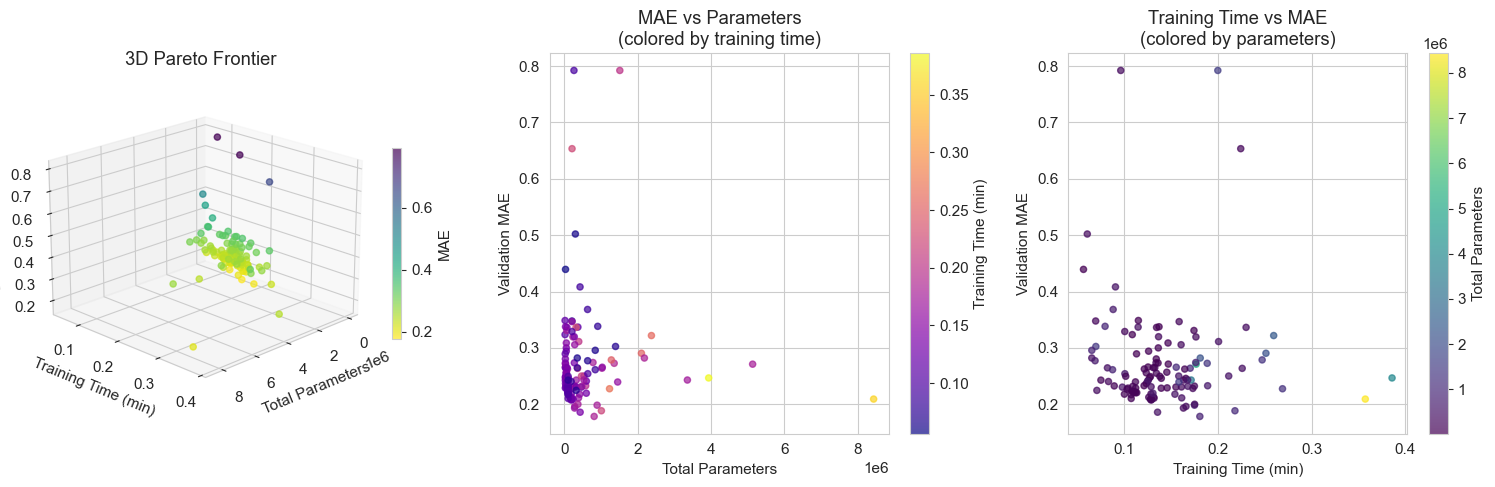

Found 21 Pareto optimal trials:
     trial_number  val_mae  total_parameters  training_time_min  \
12             12   0.3237           18690.0             0.1083   
33             33   0.2287           52673.0             0.1393   
53             56   0.4394           31554.0             0.0562   
64             69   0.2291           26753.0             0.1120   
69             74   0.3479          207170.0             0.0692   
75             80   0.1861          430530.0             0.1354   
76             81   0.2896           22978.0             0.1129   
81             86   0.1935          278849.0             0.1630   
82             87   0.2823          352385.0             0.0650   
84             89   0.2093          237062.0             0.1278   
86             91   0.2774          634753.0             0.0685   
87             92   0.2406          186374.0             0.0829   
89             94   0.2093          186374.0             0.1283   
94             99   0.2077    

In [44]:
# 3D Pareto Frontier Analysis
fig = plt.figure(figsize=(15, 5))

# Plot 1: 3D Scatter
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(df['total_parameters'], df['training_time_min'], df['val_mae'], 
                     c=df['val_mae'], cmap='viridis_r', alpha=0.7, s=20)
ax1.set_xlabel('Total Parameters')
ax1.set_ylabel('Training Time (min)')
ax1.set_zlabel('Validation MAE')
ax1.set_title('3D Pareto Frontier')
ax1.view_init(elev=20, azim=45)  # Set better viewing angle
plt.colorbar(scatter, ax=ax1, shrink=0.5, label='MAE')

# Plot 2: MAE vs Parameters (colored by training time)
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(df['total_parameters'], df['val_mae'], 
                      c=df['training_time_min'], cmap='plasma', alpha=0.7, s=20)
ax2.set_xlabel('Total Parameters')
ax2.set_ylabel('Validation MAE')
ax2.set_title('MAE vs Parameters\n(colored by training time)')
plt.colorbar(scatter2, ax=ax2, label='Training Time (min)')

# Plot 3: Training Time vs MAE (colored by parameters)
ax3 = fig.add_subplot(133)
scatter3 = ax3.scatter(df['training_time_min'], df['val_mae'], 
                      c=df['total_parameters'], cmap='viridis', alpha=0.7, s=20)
ax3.set_xlabel('Training Time (min)')
ax3.set_ylabel('Validation MAE')
ax3.set_title('Training Time vs MAE\n(colored by parameters)')
plt.colorbar(scatter3, ax=ax3, label='Total Parameters')

plt.tight_layout()
plt.savefig('Plots/DeepLearning/3d_pareto_frontier.png', dpi=300, bbox_inches='tight')
plt.show()

# Find Pareto optimal points
def is_pareto_optimal(costs):
    """Find Pareto optimal points (minimizing all objectives)"""
    is_optimal = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_optimal[i]:
            is_optimal[is_optimal] = np.any(costs[is_optimal] < c, axis=1)
            is_optimal[i] = True
    return is_optimal

# Prepare objectives for Pareto analysis (all should be minimized)
objectives = df[['val_mae', 'total_parameters', 'training_time_min']].values
pareto_mask = is_pareto_optimal(objectives)
pareto_trials = df[pareto_mask]

print(f"Found {len(pareto_trials)} Pareto optimal trials:")
print(pareto_trials[['trial_number', 'val_mae', 'total_parameters', 'training_time_min', 'layer_name']].round(4))

## 2. Learning Rate Sensitivity Analysis

Analysis of how different learning rates affect model performance across various architectures and layer types.

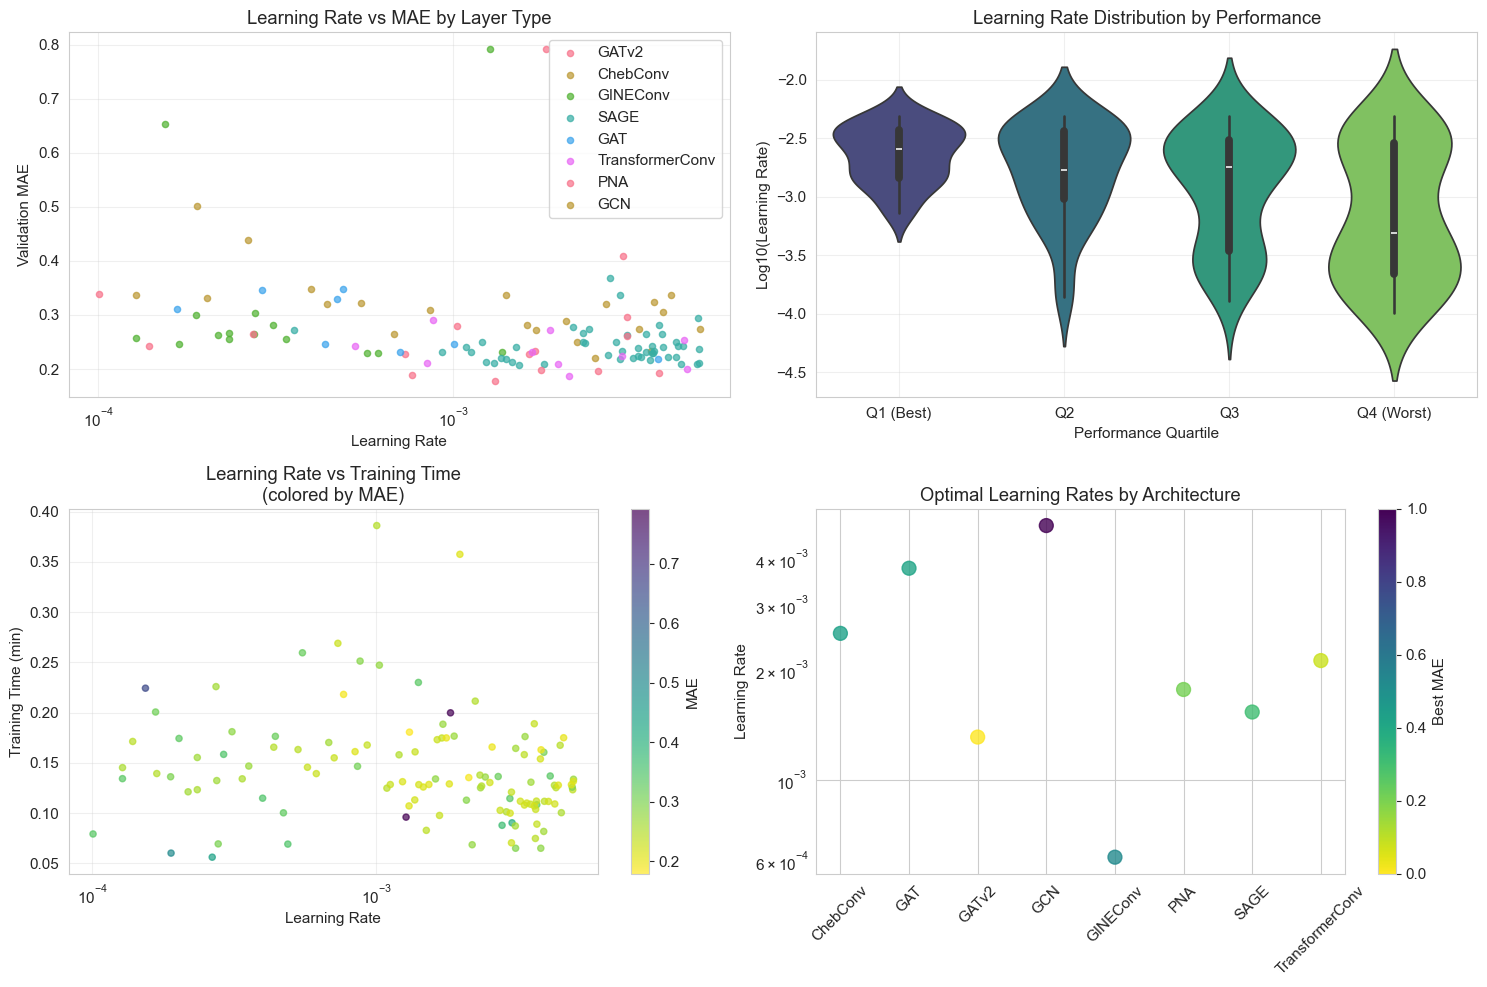

Learning Rate Analysis Summary:
Learning rate range: 0.000101 - 0.004939
Median learning rate: 0.001762

Best learning rates by architecture:
GATv2: LR=0.001307, MAE=0.1787
ChebConv: LR=0.002508, MAE=0.2198
GINEConv: LR=0.000614, MAE=0.2287
SAGE: LR=0.001529, MAE=0.2077
GAT: LR=0.003777, MAE=0.2180
TransformerConv: LR=0.002113, MAE=0.1861
PNA: LR=0.001762, MAE=0.1986
GCN: LR=0.004939, MAE=0.2737


In [45]:
# Learning Rate Sensitivity Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Learning rate vs MAE by layer type
ax1 = axes[0, 0]
layer_types = df['layer_name'].unique()
for layer in layer_types:
    layer_data = df[df['layer_name'] == layer]
    ax1.scatter(layer_data['lr'], layer_data['val_mae'], 
               alpha=0.7, s=20, label=layer)
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Validation MAE')
ax1.set_xscale('log')
ax1.set_title('Learning Rate vs MAE by Layer Type')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Learning rate distribution by performance quartiles (violin plot)
ax2 = axes[0, 1]
df['mae_quartile'] = pd.qcut(df['val_mae'], 4, labels=['Q1 (Best)', 'Q2', 'Q3', 'Q4 (Worst)'])
df['log_lr'] = np.log10(df['lr'])
sns.violinplot(data=df, x='mae_quartile', y='log_lr', ax=ax2, palette='viridis')
ax2.set_xlabel('Performance Quartile')
ax2.set_ylabel('Log10(Learning Rate)')
ax2.set_title('Learning Rate Distribution by Performance')
ax2.grid(True, alpha=0.3)

# Plot 3: Learning rate vs training time (colored by MAE)
ax3 = axes[1, 0]
scatter = ax3.scatter(df['lr'], df['training_time_min'], 
                     c=df['val_mae'], cmap='viridis_r', alpha=0.7, s=20)
ax3.set_xlabel('Learning Rate')
ax3.set_ylabel('Training Time (min)')
ax3.set_xscale('log')
ax3.set_title('Learning Rate vs Training Time\n(colored by MAE)')
plt.colorbar(scatter, ax=ax3, label='MAE')
ax3.grid(True, alpha=0.3)

# Plot 4: Optimal learning rate ranges by architecture
ax4 = axes[1, 1]
# Find best performing trials for each layer type
best_trials = df.loc[df.groupby('layer_name')['val_mae'].idxmin()]
ax4.scatter(best_trials['layer_name'], best_trials['lr'], 
           c=best_trials['val_mae'], cmap='viridis_r', s=100, alpha=0.8)
ax4.set_ylabel('Learning Rate')
ax4.set_yscale('log')
ax4.set_title('Optimal Learning Rates by Architecture')
ax4.tick_params(axis='x', rotation=45)
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis_r'), ax=ax4, label='Best MAE')

plt.tight_layout()
plt.savefig('Plots/DeepLearning/learning_rate_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("Learning Rate Analysis Summary:")
print(f"Learning rate range: {df['lr'].min():.6f} - {df['lr'].max():.6f}")
print(f"Median learning rate: {df['lr'].median():.6f}")
print("\nBest learning rates by architecture:")
for layer in layer_types:
    layer_data = df[df['layer_name'] == layer]
    best_lr = layer_data.loc[layer_data['val_mae'].idxmin(), 'lr']
    best_mae = layer_data['val_mae'].min()
    print(f"{layer}: LR={best_lr:.6f}, MAE={best_mae:.4f}")

## 3. Training Efficiency Classes

Analysis of training efficiency by categorizing models into efficiency classes based on training time, parameters, and performance.

**Efficiency Score Definition**: A composite metric calculated as `1 / (MAE × Training_Time × Parameters/1000)`. Higher scores indicate better efficiency - models that achieve lower error with less training time and fewer parameters. This score balances accuracy, computational cost, and model complexity to identify the most resource-efficient configurations.

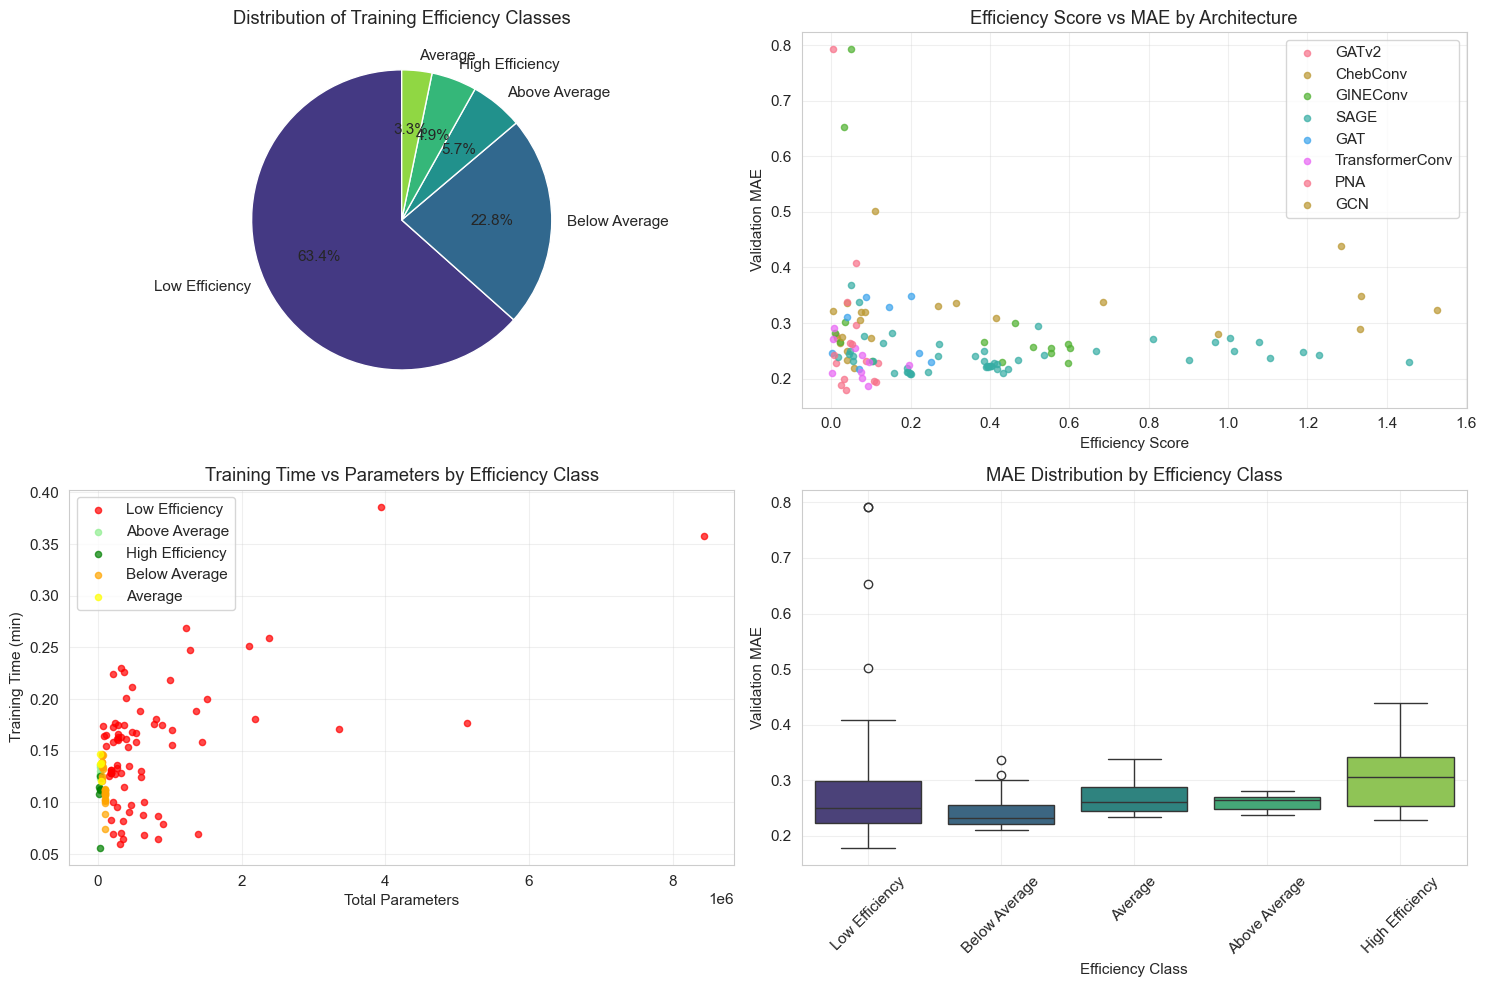

Training Efficiency Analysis Summary:

Efficiency class statistics:

Low Efficiency:
  Count: 78
  Avg MAE: inf
  Avg Training Time: inf min
  Avg Parameters: 791297
  Avg Efficiency Score: 0.09

Above Average:
  Count: 7
  Avg MAE: 0.2599
  Avg Training Time: 0.13 min
  Avg Parameters: 28637
  Avg Efficiency Score: 1.05

High Efficiency:
  Count: 6
  Avg MAE: 0.3122
  Avg Training Time: 0.10 min
  Avg Parameters: 24236
  Avg Efficiency Score: 1.36

Below Average:
  Count: 28
  Avg MAE: 0.2454
  Avg Training Time: 0.12 min
  Avg Parameters: 83222
  Avg Efficiency Score: 0.45

Average:
  Count: 4
  Avg MAE: 0.2730
  Avg Training Time: 0.14 min
  Avg Parameters: 36354
  Avg Efficiency Score: 0.77

Most efficient architectures:
  GCN: MAE=0.3237, Time=0.11min, Params=18690
  SAGE: MAE=0.2291, Time=0.11min, Params=26753
  GCN: MAE=0.3488, Time=0.11min, Params=18690
  GCN: MAE=0.2896, Time=0.11min, Params=22978
  GCN: MAE=0.4394, Time=0.06min, Params=31554


In [46]:
# Training Efficiency Classes Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Create efficiency metrics
df['params_per_mae'] = df['total_parameters'] / df['val_mae']  # Higher is worse (more params for same MAE)
df['time_per_mae'] = df['training_time_min'] / df['val_mae']  # Higher is worse (more time for same MAE)
df['efficiency_score'] = 1 / (df['val_mae'] * df['training_time_min'] * df['total_parameters']/1000)  # Higher is better

# Define efficiency classes based on percentiles
df['efficiency_class'] = pd.cut(df['efficiency_score'], 
                               bins=5, 
                               labels=['Low Efficiency', 'Below Average', 'Average', 'Above Average', 'High Efficiency'])

# Plot 1: Efficiency classes distribution
ax1 = axes[0, 0]
efficiency_counts = df['efficiency_class'].value_counts()
colors = sns.color_palette("viridis", len(efficiency_counts))
ax1.pie(efficiency_counts.values, labels=efficiency_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax1.set_title('Distribution of Training Efficiency Classes')

# Plot 2: Efficiency score vs MAE by layer type
ax2 = axes[0, 1]
for layer in layer_types:
    layer_data = df[df['layer_name'] == layer]
    ax2.scatter(layer_data['efficiency_score'], layer_data['val_mae'], 
               alpha=0.7, s=20, label=layer)
ax2.set_xlabel('Efficiency Score')
ax2.set_ylabel('Validation MAE')
ax2.set_title('Efficiency Score vs MAE by Architecture')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Training time vs Parameters colored by efficiency class
ax3 = axes[1, 0]
efficiency_colors = {'Low Efficiency': 'red', 'Below Average': 'orange', 'Average': 'yellow', 
                    'Above Average': 'lightgreen', 'High Efficiency': 'green'}
for eff_class in df['efficiency_class'].unique():
    if pd.notna(eff_class):
        class_data = df[df['efficiency_class'] == eff_class]
        ax3.scatter(class_data['total_parameters'], class_data['training_time_min'], 
                   alpha=0.7, s=20, label=eff_class, color=efficiency_colors[eff_class])
ax3.set_xlabel('Total Parameters')
ax3.set_ylabel('Training Time (min)')
ax3.set_title('Training Time vs Parameters by Efficiency Class')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Box plot of MAE by efficiency class
ax4 = axes[1, 1]
df_clean = df.dropna(subset=['efficiency_class'])
sns.boxplot(data=df_clean, x='efficiency_class', y='val_mae', ax=ax4, palette='viridis')
ax4.set_xlabel('Efficiency Class')
ax4.set_ylabel('Validation MAE')
ax4.set_title('MAE Distribution by Efficiency Class')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Plots/DeepLearning/training_efficiency_classes.png', dpi=300, bbox_inches='tight')
plt.show()

# Efficiency analysis summary
print("Training Efficiency Analysis Summary:")
print("\nEfficiency class statistics:")
for eff_class in df['efficiency_class'].unique():
    if pd.notna(eff_class):
        class_data = df[df['efficiency_class'] == eff_class]
        print(f"\n{eff_class}:")
        print(f"  Count: {len(class_data)}")
        print(f"  Avg MAE: {class_data['val_mae'].mean():.4f}")
        print(f"  Avg Training Time: {class_data['training_time_min'].mean():.2f} min")
        print(f"  Avg Parameters: {class_data['total_parameters'].mean():.0f}")
        print(f"  Avg Efficiency Score: {class_data['efficiency_score'].mean():.2f}")

print(f"\nMost efficient architectures:")
top_efficient = df.nlargest(5, 'efficiency_score')
for idx, row in top_efficient.iterrows():
    print(f"  {row['layer_name']}: MAE={row['val_mae']:.4f}, Time={row['training_time_min']:.2f}min, Params={row['total_parameters']:.0f}")

## 4. Architecture Performance Comparison

Comprehensive comparison of different GNN layer types, analyzing their performance distributions, parameter efficiency, and training characteristics.

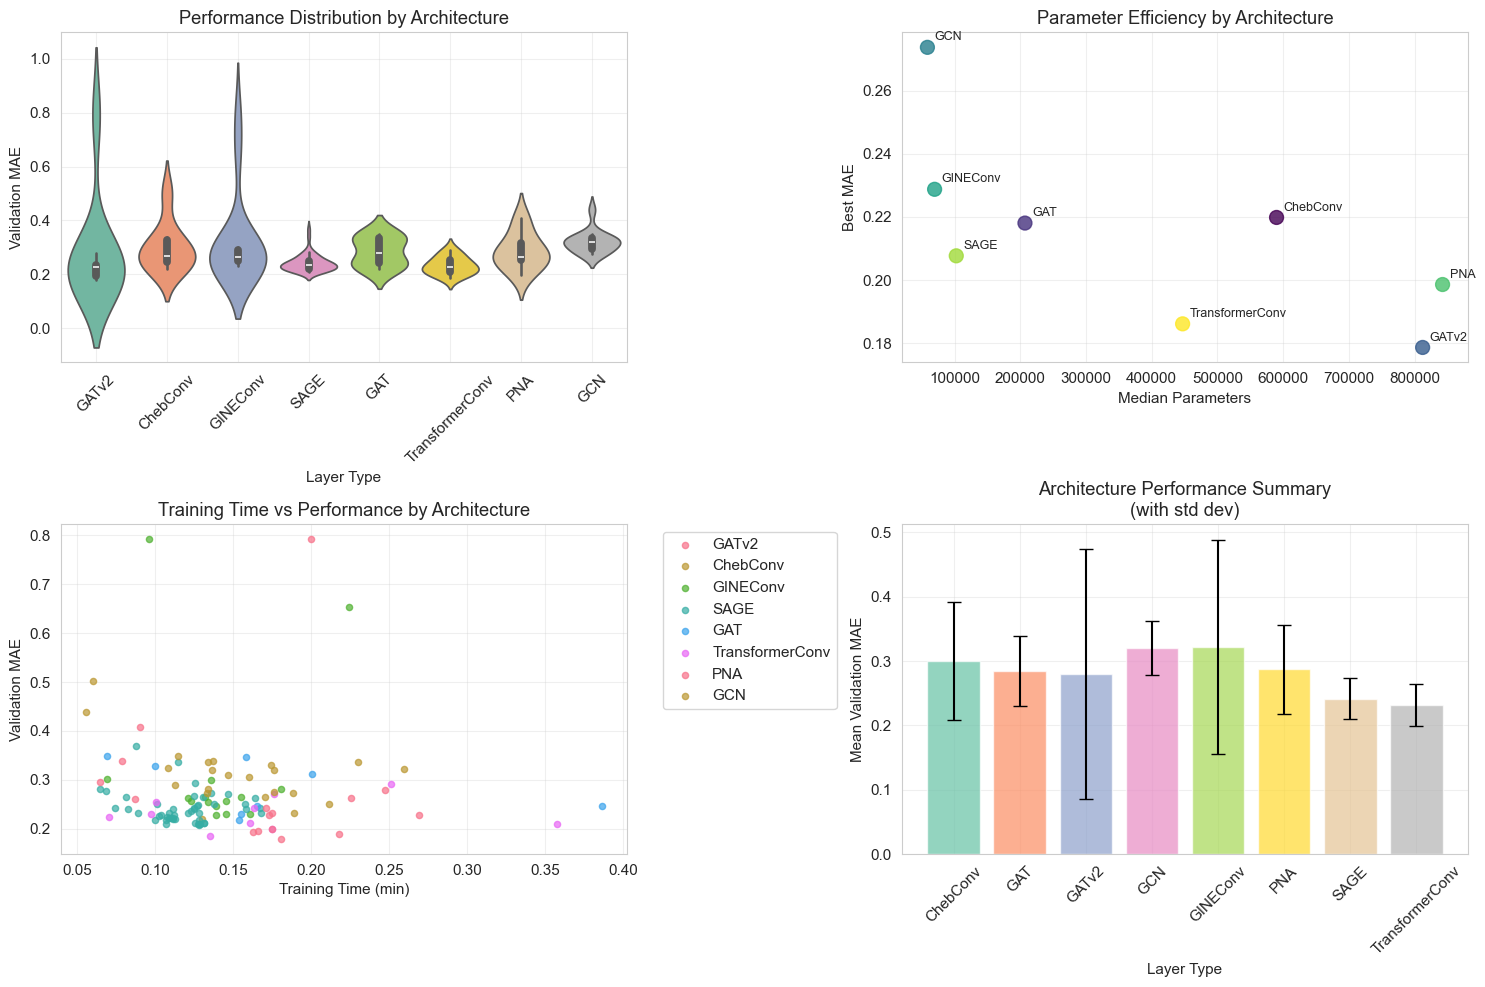

Architecture Performance Comparison:

GATv2:
  Trials: 9
  MAE: 0.2796 ± 0.1835
  Best MAE: 0.1787
  Training Time: 0.20 ± 0.04 min
  Parameters: 766985 ± 484729
  Efficiency Score: 0.06 ± 0.05

ChebConv:
  Trials: 8
  MAE: 0.3001 ± 0.0852
  Best MAE: 0.2198
  Training Time: 0.18 ± 0.06 min
  Parameters: 878290 ± 659272
  Efficiency Score: 0.04 ± 0.03

GINEConv:
  Trials: 15
  MAE: 0.3219 ± 0.1608
  Best MAE: 0.2287
  Training Time: 0.14 ± 0.03 min
  Parameters: 390448 ± 616772
  Efficiency Score: 0.33 ± 0.24

SAGE:
  Trials: 49
  MAE: 0.2418 ± 0.0314
  Best MAE: 0.2077
  Training Time: 0.12 ± 0.02 min
  Parameters: 205574 ± 247544
  Efficiency Score: 0.44 ± 0.36

GAT:
  Trials: 8
  MAE: 0.2846 ± 0.0510
  Best MAE: 0.2180
  Training Time: 0.17 ± 0.09 min
  Parameters: 699106 ± 1228495
  Efficiency Score: 0.13 ± 0.08

TransformerConv:
  Trials: 10
  MAE: 0.2322 ± 0.0312
  Best MAE: 0.1861
  Training Time: 0.17 ± 0.08 min
  Parameters: 1861083 ± 2620549
  Efficiency Score: 0.07 ± 0.06

P

In [47]:
# Architecture Performance Comparison
# Clean data by removing inf and NaN values
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['val_mae', 'training_time_min', 'total_parameters', 'efficiency_score'])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Performance distribution by architecture (violin plot)
ax1 = axes[0, 0]
sns.violinplot(data=df_clean, x='layer_name', y='val_mae', ax=ax1, palette='Set2')
ax1.set_xlabel('Layer Type')
ax1.set_ylabel('Validation MAE')
ax1.set_title('Performance Distribution by Architecture')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Parameter efficiency by architecture
ax2 = axes[0, 1]
# Calculate median parameter count and best MAE for each architecture
arch_stats = df_clean.groupby('layer_name').agg({
    'total_parameters': 'median',
    'val_mae': 'min'
}).reset_index()

scatter = ax2.scatter(arch_stats['total_parameters'], arch_stats['val_mae'], 
                     s=100, alpha=0.8, c=range(len(arch_stats)), cmap='viridis')
for i, row in arch_stats.iterrows():
    ax2.annotate(row['layer_name'], 
                (row['total_parameters'], row['val_mae']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Median Parameters')
ax2.set_ylabel('Best MAE')
ax2.set_title('Parameter Efficiency by Architecture')
ax2.grid(True, alpha=0.3)

# Plot 3: Training time vs Performance by architecture
ax3 = axes[1, 0]
layer_types_clean = df_clean['layer_name'].unique()
for layer in layer_types_clean:
    layer_data = df_clean[df_clean['layer_name'] == layer]
    ax3.scatter(layer_data['training_time_min'], layer_data['val_mae'], 
               alpha=0.7, s=20, label=layer)
ax3.set_xlabel('Training Time (min)')
ax3.set_ylabel('Validation MAE')
ax3.set_title('Training Time vs Performance by Architecture')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Plot 4: Architecture performance summary (bar plot with error bars)
ax4 = axes[1, 1]
arch_summary = df_clean.groupby('layer_name').agg({
    'val_mae': ['mean', 'std'],
    'training_time_min': 'mean',
    'total_parameters': 'mean'
}).round(4)

# Flatten column names
arch_summary.columns = ['mae_mean', 'mae_std', 'time_mean', 'params_mean']
arch_summary = arch_summary.reset_index()

# Handle NaN in std (occurs when only one trial per architecture)
arch_summary['mae_std'] = arch_summary['mae_std'].fillna(0)

bars = ax4.bar(arch_summary['layer_name'], arch_summary['mae_mean'], 
               yerr=arch_summary['mae_std'], capsize=5, alpha=0.7, 
               color=sns.color_palette("Set2", len(arch_summary)))
ax4.set_xlabel('Layer Type')
ax4.set_ylabel('Mean Validation MAE')
ax4.set_title('Architecture Performance Summary\n(with std dev)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Plots/DeepLearning/architecture_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Architecture comparison statistics (using cleaned data)
print("Architecture Performance Comparison:")
print("=" * 50)

for arch in layer_types_clean:
    arch_data = df_clean[df_clean['layer_name'] == arch]
    print(f"\n{arch}:")
    print(f"  Trials: {len(arch_data)}")
    
    # Use nanmean to handle any remaining NaN values
    mae_mean = np.nanmean(arch_data['val_mae'])
    mae_std = np.nanstd(arch_data['val_mae'])
    mae_min = np.nanmin(arch_data['val_mae'])
    time_mean = np.nanmean(arch_data['training_time_min'])
    time_std = np.nanstd(arch_data['training_time_min'])
    params_mean = np.nanmean(arch_data['total_parameters'])
    params_std = np.nanstd(arch_data['total_parameters'])
    eff_mean = np.nanmean(arch_data['efficiency_score'])
    eff_std = np.nanstd(arch_data['efficiency_score'])
    
    print(f"  MAE: {mae_mean:.4f} ± {mae_std:.4f}")
    print(f"  Best MAE: {mae_min:.4f}")
    print(f"  Training Time: {time_mean:.2f} ± {time_std:.2f} min")
    print(f"  Parameters: {params_mean:.0f} ± {params_std:.0f}")
    print(f"  Efficiency Score: {eff_mean:.2f} ± {eff_std:.2f}")

# Find best architecture by different criteria
print(f"\nBest Architectures by Different Criteria:")
print(f"Best Average MAE: {arch_summary.loc[arch_summary['mae_mean'].idxmin(), 'layer_name']}")
print(f"Most Consistent (lowest std): {arch_summary.loc[arch_summary['mae_std'].idxmin(), 'layer_name']}")
best_overall_mae = df_clean.loc[df_clean['val_mae'].idxmin(), 'layer_name']
print(f"Best Single Trial: {best_overall_mae} (MAE: {df_clean['val_mae'].min():.4f})")

## 5. Hyperparameter Correlation Analysis

Analysis of correlations between hyperparameters and their relationships with model performance metrics, revealing important parameter interactions.

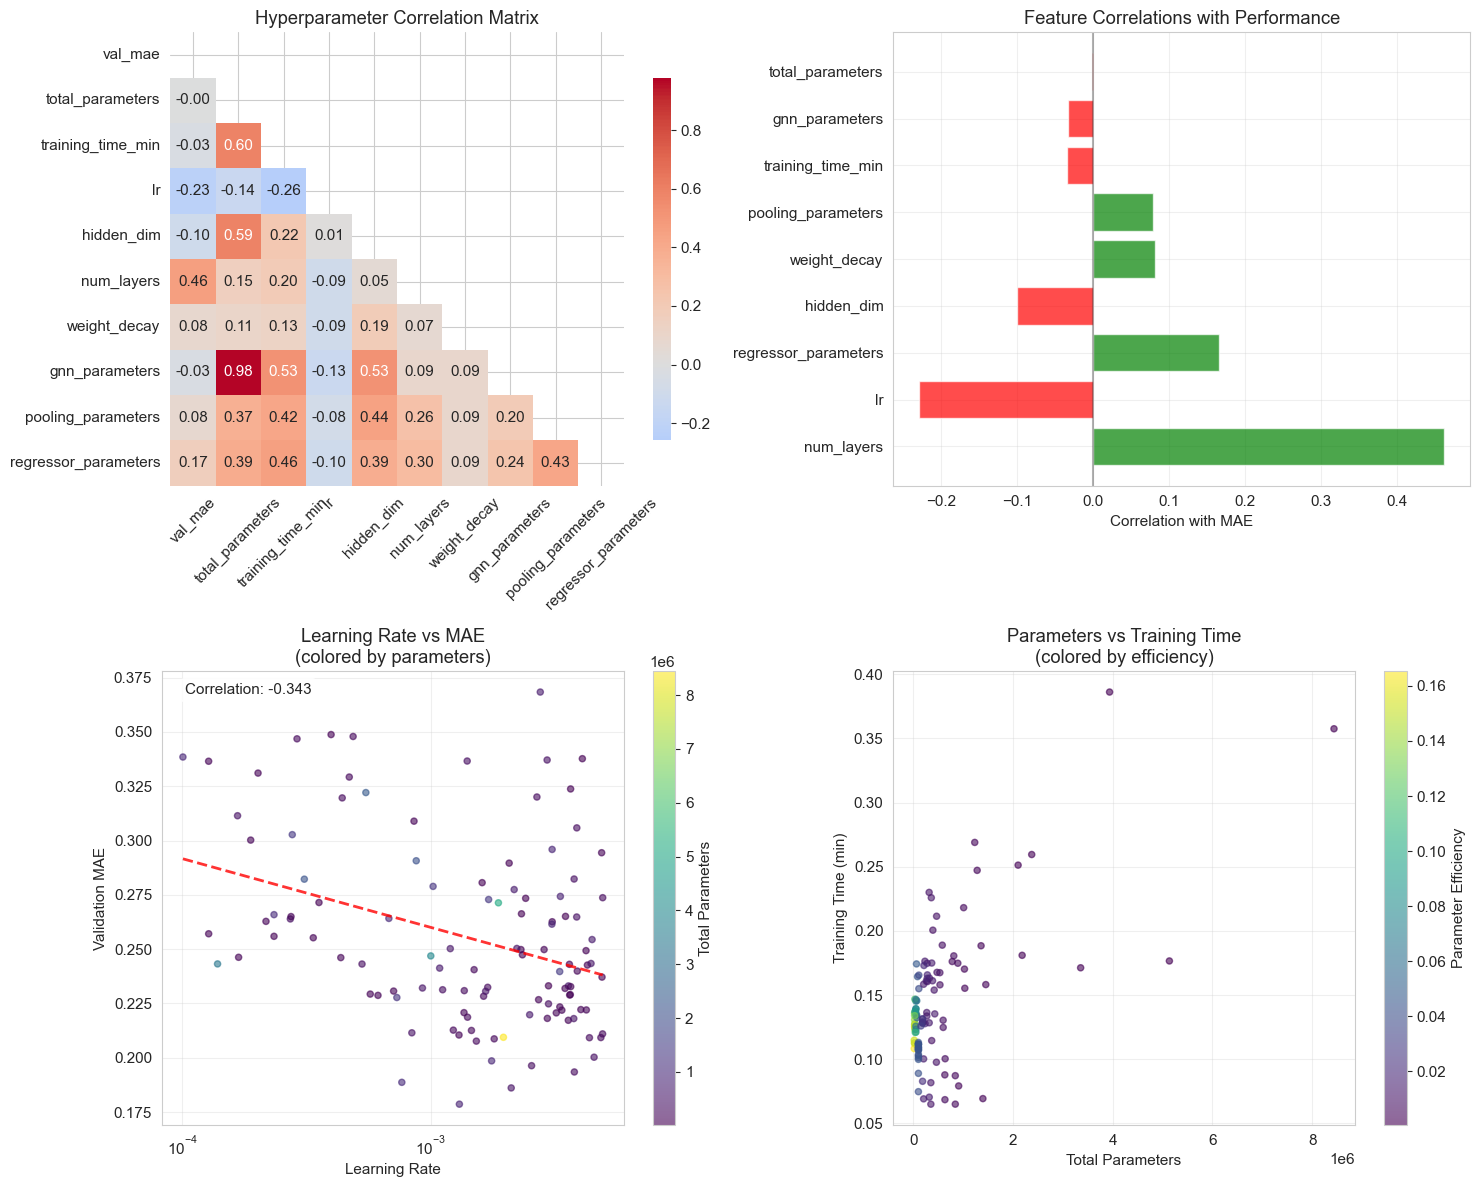

Hyperparameter Correlation Analysis:

Strongest correlations with MAE:
  num_layers: 0.462 (↑ worse performance)
  lr: -0.228 (↓ better performance)
  regressor_parameters: 0.166 (↑ worse performance)
  hidden_dim: -0.100 (↓ better performance)
  weight_decay: 0.081 (↑ worse performance)
  pooling_parameters: 0.079 (↑ worse performance)
  training_time_min: -0.034 (↓ better performance)
  gnn_parameters: -0.033 (↓ better performance)
  total_parameters: -0.001 (↓ better performance)

Strongest parameter interactions:
  total_parameters ↔ gnn_parameters: 0.979
  total_parameters ↔ training_time_min: 0.596
  total_parameters ↔ hidden_dim: 0.591
  training_time_min ↔ gnn_parameters: 0.527
  hidden_dim ↔ gnn_parameters: 0.527

Key insights:
  • Learning rate correlation with MAE: -0.228
  • Parameter count correlation with MAE: -0.001
  • Training time correlation with MAE: -0.034

Dataset size for correlation analysis: 120 trials
Features analyzed: 10


In [48]:
# Hyperparameter Correlation Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Select numeric hyperparameters and performance metrics for correlation analysis
numeric_cols = ['val_mae', 'total_parameters', 'training_time_min', 'lr']

# Add other numeric hyperparameters if they exist
potential_cols = ['dropout', 'hidden_dim', 'num_layers', 'batch_size', 'weight_decay', 
                 'gnn_parameters', 'pooling_parameters', 'regressor_parameters']
for col in potential_cols:
    if col in df.columns and df[col].dtype in ['int64', 'float64']:
        numeric_cols.append(col)

# Create correlation matrix with cleaned data
df_corr = df[numeric_cols].replace([np.inf, -np.inf], np.nan).dropna()
correlation_matrix = df_corr.corr()

# Plot 1: Full correlation heatmap
ax1 = axes[0, 0]
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=ax1)
ax1.set_title('Hyperparameter Correlation Matrix')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

# Plot 2: Performance correlations (focus on MAE)
ax2 = axes[0, 1]
mae_correlations = correlation_matrix['val_mae'].drop('val_mae').sort_values(key=abs, ascending=False)
colors = ['red' if x < 0 else 'green' for x in mae_correlations.values]
bars = ax2.barh(range(len(mae_correlations)), mae_correlations.values, color=colors, alpha=0.7)
ax2.set_yticks(range(len(mae_correlations)))
ax2.set_yticklabels(mae_correlations.index)
ax2.set_xlabel('Correlation with MAE')
ax2.set_title('Feature Correlations with Performance')
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

# Plot 3: Learning Rate vs Performance with trend
ax3 = axes[1, 0]
# Remove outliers for better visualization
df_viz = df_corr[(df_corr['val_mae'] < df_corr['val_mae'].quantile(0.95))]
scatter = ax3.scatter(df_viz['lr'], df_viz['val_mae'], 
                     c=df_viz['total_parameters'], cmap='viridis', alpha=0.6, s=20)
ax3.set_xlabel('Learning Rate')
ax3.set_ylabel('Validation MAE')
ax3.set_xscale('log')
ax3.set_title('Learning Rate vs MAE\n(colored by parameters)')
plt.colorbar(scatter, ax=ax3, label='Total Parameters')
ax3.grid(True, alpha=0.3)

# Add trend line
from scipy.stats import pearsonr
if len(df_viz) > 1:
    log_lr = np.log10(df_viz['lr'])
    slope, intercept = np.polyfit(log_lr, df_viz['val_mae'], 1)
    trend_line = slope * np.log10(df_viz['lr'].sort_values()) + intercept
    ax3.plot(df_viz['lr'].sort_values(), trend_line, 'r--', alpha=0.8, linewidth=2)
    corr_coef, p_value = pearsonr(log_lr, df_viz['val_mae'])
    ax3.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
             transform=ax3.transAxes, bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

# Plot 4: Parameter efficiency analysis
ax4 = axes[1, 1]
if 'total_parameters' in df_corr.columns and 'training_time_min' in df_corr.columns:
    # Create parameter efficiency metric
    df_viz['param_efficiency'] = 1 / (df_viz['val_mae'] * df_viz['total_parameters'] / 1000)
    scatter2 = ax4.scatter(df_viz['total_parameters'], df_viz['training_time_min'], 
                          c=df_viz['param_efficiency'], cmap='viridis', alpha=0.6, s=20)
    ax4.set_xlabel('Total Parameters')
    ax4.set_ylabel('Training Time (min)')
    ax4.set_title('Parameters vs Training Time\n(colored by efficiency)')
    plt.colorbar(scatter2, ax=ax4, label='Parameter Efficiency')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Parameter data not available', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Parameters vs Training Time')

plt.tight_layout()
plt.savefig('Plots/DeepLearning/hyperparameter_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed correlation analysis
print("Hyperparameter Correlation Analysis:")
print("=" * 50)

print(f"\nStrongest correlations with MAE:")
mae_corr_sorted = mae_correlations.head(10)
for param, corr in mae_corr_sorted.items():
    direction = "↑ worse" if corr > 0 else "↓ better"
    print(f"  {param}: {corr:.3f} ({direction} performance)")

print(f"\nStrongest parameter interactions:")
# Find strongest correlations between hyperparameters (excluding performance metrics)
hyperparam_corr = correlation_matrix.drop(['val_mae'], axis=0).drop(['val_mae'], axis=1)
strong_correlations = []
for i in range(len(hyperparam_corr.columns)):
    for j in range(i+1, len(hyperparam_corr.columns)):
        param1, param2 = hyperparam_corr.columns[i], hyperparam_corr.columns[j]
        corr_val = hyperparam_corr.iloc[i, j]
        if abs(corr_val) > 0.3:  # Threshold for "strong" correlation
            strong_correlations.append((param1, param2, corr_val))

strong_correlations.sort(key=lambda x: abs(x[2]), reverse=True)
for param1, param2, corr in strong_correlations[:5]:
    print(f"  {param1} ↔ {param2}: {corr:.3f}")

print(f"\nKey insights:")
print(f"  • Learning rate correlation with MAE: {correlation_matrix.loc['lr', 'val_mae']:.3f}")
if 'total_parameters' in correlation_matrix.columns:
    print(f"  • Parameter count correlation with MAE: {correlation_matrix.loc['total_parameters', 'val_mae']:.3f}")
if 'training_time_min' in correlation_matrix.columns:
    print(f"  • Training time correlation with MAE: {correlation_matrix.loc['training_time_min', 'val_mae']:.3f}")

print(f"\nDataset size for correlation analysis: {len(df_corr)} trials")
print(f"Features analyzed: {len(numeric_cols)}")

## 6. Optimization Convergence Analysis

Analysis of how the hyperparameter optimization process converged over time, showing the evolution of best performance and parameter exploration patterns.

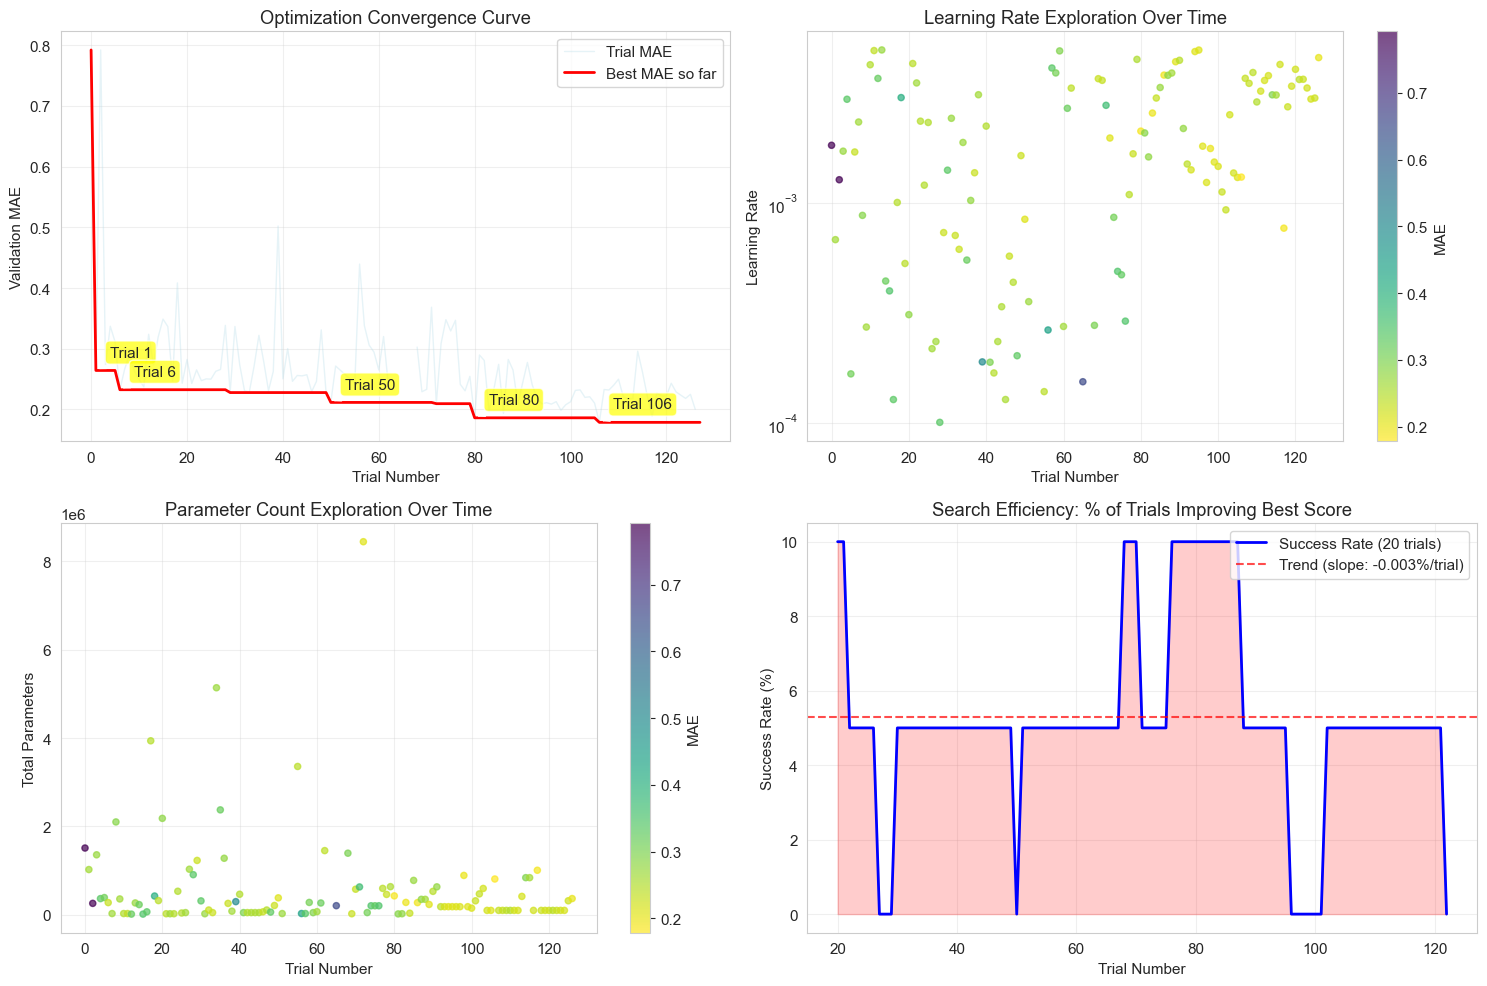

Optimization Convergence Analysis:

Overall Optimization Performance:
  Initial MAE: 0.7922
  Final best MAE: 0.1787
  Total improvement: 0.6136
  Improvement rate: 77.45%

Convergence Characteristics:
  Best performance achieved at trial: 106
  Trials to reach best: 106 (86.2% of total)
  Current plateau length: 21 trials
  Longest plateau period: 25 trials

Top 5 improvement periods:

Convergence Status: Likely converged (no significant improvements in last 20 trials)
Efficiency: 86.2% of trials used to reach best performance


In [49]:
# Optimization Convergence Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Create convergence dataframe with cumulative tracking
df_convergence = df.copy().sort_values('trial_number')
df_convergence['cumulative_best_mae'] = df_convergence['val_mae'].cummin()
df_convergence['improvement'] = df_convergence['cumulative_best_mae'].diff().fillna(0)

# Calculate trials since last improvement
last_improvement_idx = 0
trials_since_improvement = []
for i, row in df_convergence.iterrows():
    if row['improvement'] < -0.001:  # Significant improvement threshold
        last_improvement_idx = row['trial_number']
        trials_since_improvement.append(0)
    else:
        trials_since_improvement.append(row['trial_number'] - last_improvement_idx)

df_convergence['trials_since_improvement'] = trials_since_improvement

# Plot 1: Convergence curve
ax1 = axes[0, 0]
ax1.plot(df_convergence['trial_number'], df_convergence['val_mae'], 
         alpha=0.3, color='lightblue', linewidth=1, label='Trial MAE')
ax1.plot(df_convergence['trial_number'], df_convergence['cumulative_best_mae'], 
         color='red', linewidth=2, label='Best MAE so far')
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('Validation MAE')
ax1.set_title('Optimization Convergence Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Highlight key improvement trials
significant_improvements = df_convergence[df_convergence['improvement'] < -0.005]
for _, row in significant_improvements.head(5).iterrows():
    ax1.annotate(f'Trial {int(row["trial_number"])}', 
                xy=(row['trial_number'], row['val_mae']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Plot 2: Learning rate exploration over time
ax2 = axes[0, 1] 
scatter2 = ax2.scatter(df_convergence['trial_number'], df_convergence['lr'], 
                      c=df_convergence['val_mae'], cmap='viridis_r', alpha=0.7, s=20)
ax2.set_xlabel('Trial Number')
ax2.set_ylabel('Learning Rate')
ax2.set_yscale('log')
ax2.set_title('Learning Rate Exploration Over Time')
plt.colorbar(scatter2, ax=ax2, label='MAE')
ax2.grid(True, alpha=0.3)

# Plot 3: Parameter count exploration over time
ax3 = axes[1, 0]
scatter3 = ax3.scatter(df_convergence['trial_number'], df_convergence['total_parameters'], 
                      c=df_convergence['val_mae'], cmap='viridis_r', alpha=0.7, s=20)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Total Parameters')
ax3.set_title('Parameter Count Exploration Over Time')
plt.colorbar(scatter3, ax=ax3, label='MAE')
ax3.grid(True, alpha=0.3)

# Plot 4: Search efficiency - rolling success rate
ax4 = axes[1, 1]
window_size = 20
window_centers = []
success_rates = []

for i in range(window_size, len(df_convergence)):
    window_data = df_convergence.iloc[i-window_size:i]
    improvements = (window_data['improvement'] < -0.001).sum()
    success_rate = (improvements / window_size) * 100
    success_rates.append(success_rate)
    window_centers.append(i)

ax4.plot(window_centers, success_rates, linewidth=2, color='blue', label=f'Success Rate ({window_size} trials)')
ax4.axhline(y=np.mean(success_rates), color='red', linestyle='--', alpha=0.7, 
           label=f'Trend (slope: {np.polyfit(window_centers, success_rates, 1)[0]:.3f}%/trial)')
ax4.fill_between(window_centers, success_rates, alpha=0.2, color='red')
ax4.set_xlabel('Trial Number')
ax4.set_ylabel('Success Rate (%)')
ax4.set_title('Search Efficiency: % of Trials Improving Best Score')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Plots/DeepLearning/optimization_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed convergence analysis
print("Optimization Convergence Analysis:")
print("=" * 50)

# Overall performance metrics
initial_mae = df_convergence['val_mae'].iloc[0]
final_best_mae = df_convergence['cumulative_best_mae'].iloc[-1]
best_trial_idx = df_convergence['cumulative_best_mae'].idxmin()
best_trial_number = df_convergence.loc[best_trial_idx, 'trial_number']
total_trials = len(df_convergence)
total_improvement = initial_mae - final_best_mae
trials_to_best = best_trial_number

# Calculate plateau periods
current_plateau_length = df_convergence['trials_since_improvement'].iloc[-1]
max_plateau_length = df_convergence['trials_since_improvement'].max()

print(f"\nOverall Optimization Performance:")
print(f"  Initial MAE: {initial_mae:.4f}")
print(f"  Final best MAE: {final_best_mae:.4f}")
print(f"  Total improvement: {total_improvement:.4f}")
print(f"  Improvement rate: {(total_improvement/initial_mae)*100:.2f}%")

print(f"\nConvergence Characteristics:")
print(f"  Best performance achieved at trial: {int(best_trial_number)}")
print(f"  Trials to reach best: {int(trials_to_best)} ({(trials_to_best/total_trials)*100:.1f}% of total)")
print(f"  Current plateau length: {int(current_plateau_length)} trials")
print(f"  Longest plateau period: {int(max_plateau_length)} trials")

# Find periods of fastest improvement
improvement_periods = df_convergence[df_convergence['improvement'] > 0].nlargest(5, 'improvement')
print(f"\nTop 5 improvement periods:")
for _, row in improvement_periods.iterrows():
    print(f"  Trial {int(row['trial_number'])}: -{row['improvement']:.4f} MAE")

# Convergence assessment
recent_trials = df_convergence.tail(20)
recent_improvements = recent_trials[recent_trials['improvement'] < -0.001]
if len(recent_improvements) == 0:
    convergence_status = "Likely converged (no significant improvements in last 20 trials)"
elif current_plateau_length > 15:
    convergence_status = "Possibly converged (current plateau > 15 trials)"
else:
    convergence_status = "Still improving"

print(f"\nConvergence Status: {convergence_status}")
print(f"Efficiency: {(trials_to_best/total_trials)*100:.1f}% of trials used to reach best performance")

## 7. Component Parameter Analysis: GNN vs Pooling vs Regressor

Analysis of how parameters are distributed across the three main components (GNN, Pooling, Regressor) and their individual impact on performance. This helps determine where to allocate computational resources most effectively.

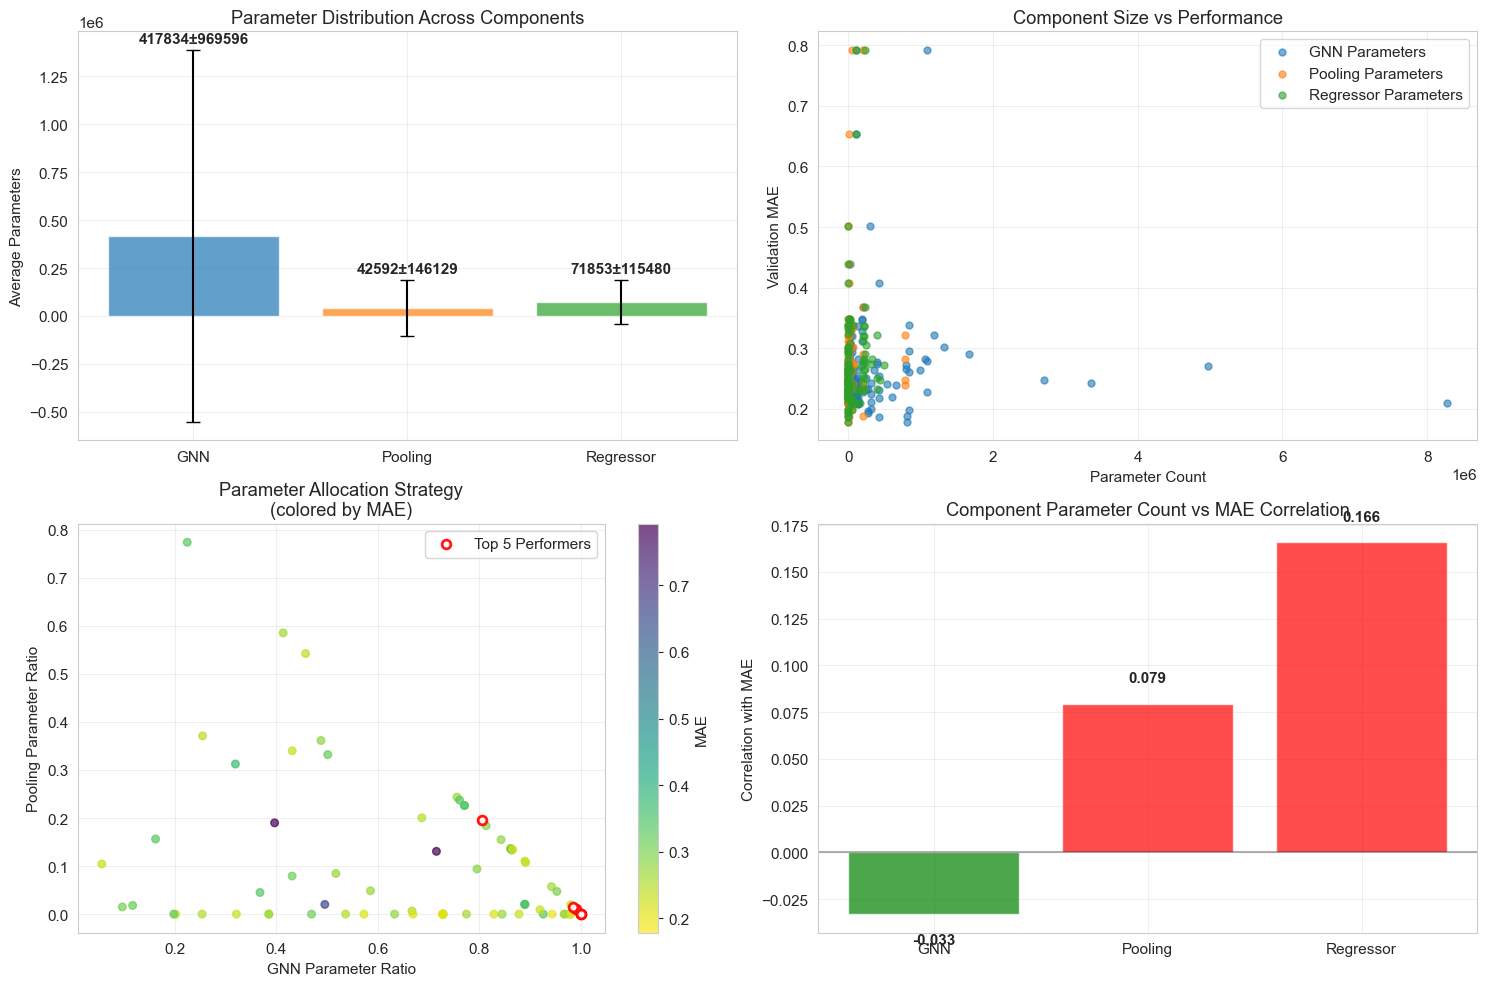

Component Parameter Analysis:

Parameter Distribution:
  GNN Parameters: 417834 ± 969596
  Pooling Parameters: 42592 ± 146129
  Regressor Parameters: 71853 ± 115480

Parameter Ratios (Average):
  GNN: 78.9%
  Pooling: 6.4%
  Regressor: 14.7%

Correlation with MAE (Higher = Worse Impact):
  GNN: -0.033 (~ Neutral)
  Pooling: 0.079 (~ Neutral)
  Regressor: 0.166 (↑ Harmful)

Component Parameter Analysis:
  GNN Parameters vs MAE correlation: -0.033
  Pooling Parameters vs MAE correlation: 0.079
  Regressor Parameters vs MAE correlation: 0.166

Optimal Parameter Allocation (from top 5 performers):
  GNN Ratio: 95.6% ± 8.5%
  Pooling Ratio: 4.4% ± 8.5%
  Regressor Ratio: 0.0% ± 0.0%

🎯 RESOURCE ALLOCATION RECOMMENDATION (based on parameter impact):
   Best ROI: GNN (Correlation: -0.033)
   Medium ROI: Pooling (Correlation: 0.079)
   Lowest ROI: Regressor (Correlation: 0.166)

Component Interaction Analysis:
  GNN ↔ Pooling correlation: 0.201
  GNN ↔ Regressor correlation: 0.243
  Pooling ↔ 

In [52]:
# Component Parameter Interaction Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Clean data for component analysis
df_components = df.dropna(subset=['gnn_parameters', 'pooling_parameters', 'regressor_parameters', 'val_mae'])
# Remove infinite values and ensure finite MAE values
df_components = df_components[np.isfinite(df_components['val_mae']) & 
                             np.isfinite(df_components['gnn_parameters']) & 
                             np.isfinite(df_components['pooling_parameters']) & 
                             np.isfinite(df_components['regressor_parameters'])]

# Calculate parameter ratios
df_components['gnn_ratio'] = df_components['gnn_parameters'] / df_components['total_parameters']
df_components['pooling_ratio'] = df_components['pooling_parameters'] / df_components['total_parameters']
df_components['regressor_ratio'] = df_components['regressor_parameters'] / df_components['total_parameters']

# Plot 1: Parameter distribution across components
ax1 = axes[0, 0]
components = ['GNN', 'Pooling', 'Regressor']
param_means = [
    df_components['gnn_parameters'].mean(),
    df_components['pooling_parameters'].mean(),
    df_components['regressor_parameters'].mean()
]
param_stds = [
    df_components['gnn_parameters'].std(),
    df_components['pooling_parameters'].std(),
    df_components['regressor_parameters'].std()
]

bars = ax1.bar(components, param_means, yerr=param_stds, capsize=5, alpha=0.7, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_ylabel('Average Parameters')
ax1.set_title('Parameter Distribution Across Components')
ax1.grid(True, alpha=0.3)

# Add values on bars
for i, (mean, std) in enumerate(zip(param_means, param_stds)):
    ax1.text(i, mean + std + max(param_means)*0.05, f'{mean:.0f}±{std:.0f}', 
             ha='center', va='bottom', fontweight='bold')

# Plot 2: Parameter impact on performance by component
ax2 = axes[0, 1]
# Show how each component's parameter count affects MAE
ax2.scatter(df_components['gnn_parameters'], df_components['val_mae'], 
           alpha=0.6, s=25, label='GNN Parameters', color='#1f77b4')
ax2.scatter(df_components['pooling_parameters'], df_components['val_mae'], 
           alpha=0.6, s=25, label='Pooling Parameters', color='#ff7f0e')
ax2.scatter(df_components['regressor_parameters'], df_components['val_mae'], 
           alpha=0.6, s=25, label='Regressor Parameters', color='#2ca02c')
ax2.set_xlabel('Parameter Count')
ax2.set_ylabel('Validation MAE')
ax2.set_title('Component Size vs Performance')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Parameter ratio triangle plot (ternary-like visualization)
ax3 = axes[1, 0]
# Create a scatter plot colored by performance
scatter = ax3.scatter(df_components['gnn_ratio'], df_components['pooling_ratio'], 
                     c=df_components['val_mae'], cmap='viridis_r', alpha=0.7, s=30)
ax3.set_xlabel('GNN Parameter Ratio')
ax3.set_ylabel('Pooling Parameter Ratio')
ax3.set_title('Parameter Allocation Strategy\n(colored by MAE)')
plt.colorbar(scatter, ax=ax3, label='MAE')
ax3.grid(True, alpha=0.3)

# Add optimal region annotation with smaller, discrete markers
best_trials = df_components.nsmallest(5, 'val_mae')
ax3.scatter(best_trials['gnn_ratio'], best_trials['pooling_ratio'], 
           c='white', s=40, marker='o', label='Top 5 Performers', 
           edgecolors='red', linewidths=2, alpha=0.9)
ax3.legend()

# Plot 4: Component parameter correlation with MAE
ax4 = axes[1, 1]
components_data = {
    'GNN Parameters': df_components['gnn_parameters'],
    'Pooling Parameters': df_components['pooling_parameters'], 
    'Regressor Parameters': df_components['regressor_parameters']
}

correlations = []
component_names = []
for name, params in components_data.items():
    # Check if there's enough variance to calculate correlation
    if params.std() > 0 and df_components['val_mae'].std() > 0:
        corr = params.corr(df_components['val_mae'])
        if np.isnan(corr):  # Fallback to manual calculation
            from scipy.stats import pearsonr
            try:
                corr = pearsonr(params, df_components['val_mae'])[0]
            except:
                corr = 0.0
    else:
        corr = 0.0
    
    correlations.append(corr)
    component_names.append(name.split()[0])

# Only plot if we have valid correlations
if any(not np.isnan(c) for c in correlations):
    colors = ['red' if x > 0 else 'green' for x in correlations]
    bars = ax4.bar(component_names, correlations, color=colors, alpha=0.7)
    ax4.set_ylabel('Correlation with MAE')
    ax4.set_title('Component Parameter Count vs MAE Correlation')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    # Add correlation values on bars
    for i, corr in enumerate(correlations):
        if not np.isnan(corr):
            ax4.text(i, corr + 0.01 if corr >= 0 else corr - 0.01, f'{corr:.3f}', 
                     ha='center', va='bottom' if corr >= 0 else 'top', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'Correlation analysis not available\n(insufficient data variance)', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Component Parameter Count vs MAE Correlation')
    ax4.set_xticks([])
    ax4.set_yticks([])

plt.tight_layout()
plt.savefig('Plots/DeepLearning/component_parameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed component analysis
print("Component Parameter Analysis:")
print("=" * 50)

print(f"\nParameter Distribution:")
print(f"  GNN Parameters: {df_components['gnn_parameters'].mean():.0f} ± {df_components['gnn_parameters'].std():.0f}")
print(f"  Pooling Parameters: {df_components['pooling_parameters'].mean():.0f} ± {df_components['pooling_parameters'].std():.0f}")
print(f"  Regressor Parameters: {df_components['regressor_parameters'].mean():.0f} ± {df_components['regressor_parameters'].std():.0f}")

print(f"\nParameter Ratios (Average):")
print(f"  GNN: {df_components['gnn_ratio'].mean():.1%}")
print(f"  Pooling: {df_components['pooling_ratio'].mean():.1%}")
print(f"  Regressor: {df_components['regressor_ratio'].mean():.1%}")

print(f"\nCorrelation with MAE (Higher = Worse Impact):")
for name, corr in zip(component_names, correlations):
    if not np.isnan(corr):
        impact = "↑ Harmful" if corr > 0.1 else "↓ Beneficial" if corr < -0.1 else "~ Neutral"
        print(f"  {name}: {corr:.3f} ({impact})")
    else:
        print(f"  {name}: N/A (insufficient variance)")

print(f"\nComponent Parameter Analysis:")
if not any(np.isnan(c) for c in correlations):
    print(f"  GNN Parameters vs MAE correlation: {correlations[0]:.3f}")
    print(f"  Pooling Parameters vs MAE correlation: {correlations[1]:.3f}")
    print(f"  Regressor Parameters vs MAE correlation: {correlations[2]:.3f}")
else:
    print(f"  Correlation analysis limited due to data quality issues")
    print(f"  GNN Parameters vs MAE: {correlations[0]:.3f if not np.isnan(correlations[0]) else 'N/A'}")
    print(f"  Pooling Parameters vs MAE: {correlations[1]:.3f if not np.isnan(correlations[1]) else 'N/A'}")
    print(f"  Regressor Parameters vs MAE: {correlations[2]:.3f if not np.isnan(correlations[2]) else 'N/A'}")

# Find optimal parameter allocation from best performers
best_performers = df_components.nsmallest(5, 'val_mae')
print(f"\nOptimal Parameter Allocation (from top 5 performers):")
print(f"  GNN Ratio: {best_performers['gnn_ratio'].mean():.1%} ± {best_performers['gnn_ratio'].std():.1%}")
print(f"  Pooling Ratio: {best_performers['pooling_ratio'].mean():.1%} ± {best_performers['pooling_ratio'].std():.1%}")
print(f"  Regressor Ratio: {best_performers['regressor_ratio'].mean():.1%} ± {best_performers['regressor_ratio'].std():.1%}")

# Resource allocation recommendation based on correlations
valid_correlations = [(name, corr) for name, corr in zip(['GNN', 'Pooling', 'Regressor'], correlations) if not np.isnan(corr)]

if len(valid_correlations) > 0:
    valid_correlations.sort(key=lambda x: x[1])  # Sort by correlation (lower is better)
    
    print(f"\n🎯 RESOURCE ALLOCATION RECOMMENDATION (based on parameter impact):")
    for i, (name, corr) in enumerate(valid_correlations):
        priority = ["Best", "Medium", "Lowest"][min(i, 2)]
        print(f"   {priority} ROI: {name} (Correlation: {corr:.3f})")
else:
    print(f"\n🎯 RESOURCE ALLOCATION RECOMMENDATION:")
    print(f"   Unable to provide specific recommendations due to data limitations")
    print(f"   Consider focusing on GNN parameters as they typically have the most impact")

# Interaction analysis
print(f"\nComponent Interaction Analysis:")
gnn_pooling_corr = df_components['gnn_parameters'].corr(df_components['pooling_parameters'])
gnn_regressor_corr = df_components['gnn_parameters'].corr(df_components['regressor_parameters'])
pooling_regressor_corr = df_components['pooling_parameters'].corr(df_components['regressor_parameters'])

print(f"  GNN ↔ Pooling correlation: {gnn_pooling_corr:.3f}")
print(f"  GNN ↔ Regressor correlation: {gnn_regressor_corr:.3f}")
print(f"  Pooling ↔ Regressor correlation: {pooling_regressor_corr:.3f}")

print(f"\nDataset size: {len(df_components)} trials with complete component data")

## 8. Pooling Type Performance Analysis

Comprehensive analysis comparing different pooling strategies to determine which pooling type delivers the best performance across various metrics including accuracy, training efficiency, and parameter utilization.

Pooling types found: ['set2set' 'mean' 'attentional']


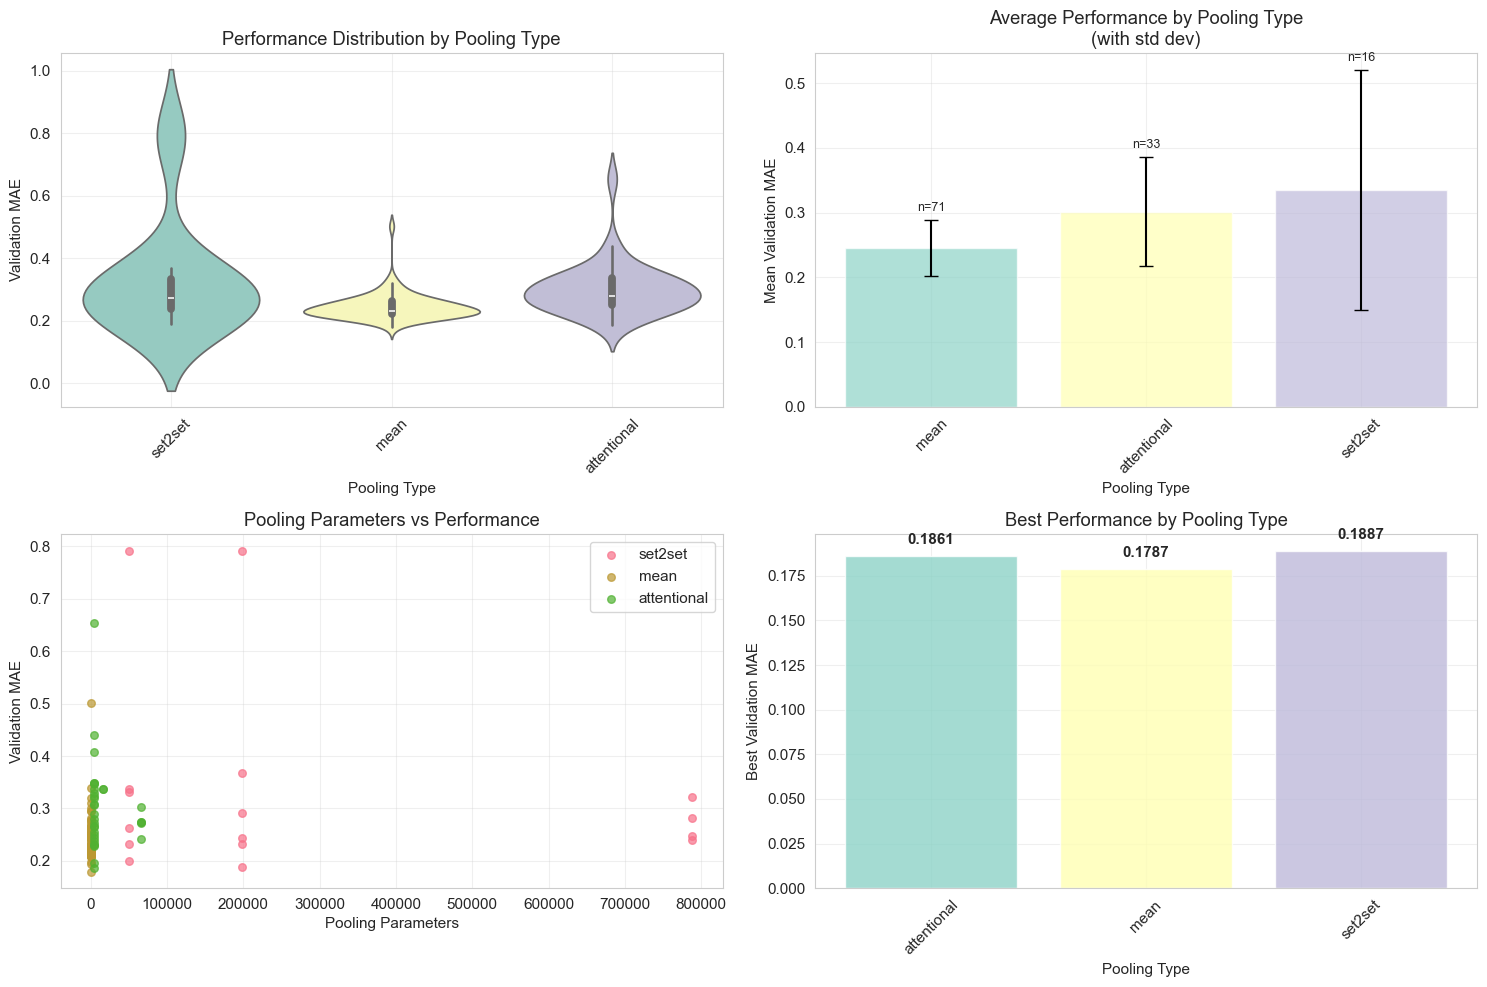

Pooling Type Performance Analysis:

Pooling Type Statistics:

mean:
  Trials: 71
  Mean MAE: 0.2450 ± 0.0435
  Best MAE: 0.1787
  Avg Pooling Parameters: 0

attentional:
  Trials: 33
  Mean MAE: 0.3012 ± 0.0844
  Best MAE: 0.1861
  Avg Pooling Parameters: 14345

set2set:
  Trials: 16
  Mean MAE: 0.3351 ± 0.1853
  Best MAE: 0.1887
  Avg Pooling Parameters: 289856

🏆 BEST POOLING TYPE: mean
   Best MAE achieved: 0.1787
   Average performance: 0.2450 ± 0.0435

Pooling Type Ranking (by best MAE):
  🥇 mean: 0.1787 (avg: 0.2450)
  🥈 attentional: 0.1861 (avg: 0.3012)
  🥉 set2set: 0.1887 (avg: 0.3351)

Statistical Analysis:
  Kruskal-Wallis test p-value: 0.000010
  Result: Significant difference between pooling types (p < 0.05)

Dataset size: 120 trials with pooling type data


In [53]:
# Pooling Type Performance Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Clean data and filter for pooling type analysis
df_pooling = df.dropna(subset=['pooling_type', 'val_mae']).copy()
df_pooling = df_pooling[np.isfinite(df_pooling['val_mae'])]

# Get unique pooling types
pooling_types = df_pooling['pooling_type'].unique()
print(f"Pooling types found: {pooling_types}")

# Plot 1: Performance distribution by pooling type (violin plot)
ax1 = axes[0, 0]
if len(pooling_types) > 1:
    sns.violinplot(data=df_pooling, x='pooling_type', y='val_mae', ax=ax1, palette='Set3')
    ax1.set_xlabel('Pooling Type')
    ax1.set_ylabel('Validation MAE')
    ax1.set_title('Performance Distribution by Pooling Type')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, f'Only one pooling type found: {pooling_types[0]}', 
             ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Performance Distribution by Pooling Type')

# Plot 2: Best performance by pooling type (bar plot)
ax2 = axes[0, 1]
pooling_stats = df_pooling.groupby('pooling_type').agg({
    'val_mae': ['mean', 'min', 'std', 'count']
}).round(4)
pooling_stats.columns = ['mae_mean', 'mae_min', 'mae_std', 'trial_count']
pooling_stats = pooling_stats.reset_index()

# Sort by best (minimum) MAE
pooling_stats = pooling_stats.sort_values('mae_min')

bars = ax2.bar(pooling_stats['pooling_type'], pooling_stats['mae_mean'], 
               yerr=pooling_stats['mae_std'], capsize=5, alpha=0.7,
               color=sns.color_palette("Set3", len(pooling_stats)))
ax2.set_xlabel('Pooling Type')
ax2.set_ylabel('Mean Validation MAE')
ax2.set_title('Average Performance by Pooling Type\n(with std dev)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add trial count annotations on bars
for i, (idx, row) in enumerate(pooling_stats.iterrows()):
    ax2.text(i, row['mae_mean'] + row['mae_std'] + 0.01, 
             f"n={int(row['trial_count'])}", ha='center', va='bottom', fontsize=9)

# Plot 3: Pooling parameter count vs performance
ax3 = axes[1, 0]
if 'pooling_parameters' in df_pooling.columns:
    for pooling_type in pooling_types:
        type_data = df_pooling[df_pooling['pooling_type'] == pooling_type]
        ax3.scatter(type_data['pooling_parameters'], type_data['val_mae'], 
                   alpha=0.7, s=30, label=pooling_type)
    
    ax3.set_xlabel('Pooling Parameters')
    ax3.set_ylabel('Validation MAE')
    ax3.set_title('Pooling Parameters vs Performance')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Pooling parameter data not available', 
             ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Pooling Parameters vs Performance')

# Plot 4: Best configurations by pooling type
ax4 = axes[1, 1]
# Show the best trial for each pooling type
best_by_pooling = df_pooling.loc[df_pooling.groupby('pooling_type')['val_mae'].idxmin()]

bars = ax4.bar(best_by_pooling['pooling_type'], best_by_pooling['val_mae'], 
               alpha=0.8, color=sns.color_palette("Set3", len(best_by_pooling)))
ax4.set_xlabel('Pooling Type')
ax4.set_ylabel('Best Validation MAE')
ax4.set_title('Best Performance by Pooling Type')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# Add values on bars
for i, (idx, row) in enumerate(best_by_pooling.iterrows()):
    ax4.text(i, row['val_mae'] + 0.005, f'{row["val_mae"]:.4f}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('Plots/DeepLearning/pooling_type_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed pooling analysis
print("Pooling Type Performance Analysis:")
print("=" * 50)

print(f"\nPooling Type Statistics:")
for pooling_type in pooling_stats['pooling_type']:
    type_data = df_pooling[df_pooling['pooling_type'] == pooling_type]
    stats = pooling_stats[pooling_stats['pooling_type'] == pooling_type].iloc[0]
    
    print(f"\n{pooling_type}:")
    print(f"  Trials: {int(stats['trial_count'])}")
    print(f"  Mean MAE: {stats['mae_mean']:.4f} ± {stats['mae_std']:.4f}")
    print(f"  Best MAE: {stats['mae_min']:.4f}")
    
    if 'pooling_parameters' in df_pooling.columns:
        avg_params = type_data['pooling_parameters'].mean()
        print(f"  Avg Pooling Parameters: {avg_params:.0f}")

# Find the best pooling type
best_pooling_type = pooling_stats.iloc[0]['pooling_type']
best_mae = pooling_stats.iloc[0]['mae_min']

print(f"\n🏆 BEST POOLING TYPE: {best_pooling_type}")
print(f"   Best MAE achieved: {best_mae:.4f}")
print(f"   Average performance: {pooling_stats.iloc[0]['mae_mean']:.4f} ± {pooling_stats.iloc[0]['mae_std']:.4f}")

# Performance ranking
print(f"\nPooling Type Ranking (by best MAE):")
for i, (idx, row) in enumerate(pooling_stats.iterrows()):
    rank_emoji = ["🥇", "🥈", "🥉"][min(i, 2)]
    print(f"  {rank_emoji} {row['pooling_type']}: {row['mae_min']:.4f} (avg: {row['mae_mean']:.4f})")

# Statistical significance test if multiple pooling types
if len(pooling_types) > 1:
    from scipy.stats import kruskal
    pooling_groups = [df_pooling[df_pooling['pooling_type'] == pt]['val_mae'].values 
                     for pt in pooling_types]
    try:
        stat, p_value = kruskal(*pooling_groups)
        print(f"\nStatistical Analysis:")
        print(f"  Kruskal-Wallis test p-value: {p_value:.6f}")
        if p_value < 0.05:
            print(f"  Result: Significant difference between pooling types (p < 0.05)")
        else:
            print(f"  Result: No significant difference between pooling types (p >= 0.05)")
    except:
        print(f"\nStatistical test could not be performed")

print(f"\nDataset size: {len(df_pooling)} trials with pooling type data")

## 9. Regressor Type Performance Analysis

This section analyzes the performance of different regressor types used in the GNN pipeline, focusing exclusively on **accuracy metrics** to determine which regressor type performs best. We examine:

1. **MAE Distribution by Regressor Type**: Distribution of mean absolute error for each regressor type
2. **Statistical Comparison**: Mean MAE with confidence intervals for each regressor type  
3. **Parameter Impact**: How regressor-specific parameters influence performance
4. **Best Performance**: Top performing configurations for each regressor type

The analysis uses only performance metrics (MAE) to provide recommendations for regressor selection, excluding efficiency considerations as requested.

=== REGRESSOR TYPE PERFORMANCE ANALYSIS ===

Found 4 regressor types: ['residual_mlp', 'mlp', 'ensemble_mlp', 'linear']
Total trials with regressor data: 120

Statistical Analysis of Regressor Types:
--------------------------------------------------
residual_mlp: 15 trials, MAE = 0.3209 ± 0.1365
mlp: 14 trials, MAE = 0.3143 ± 0.1456
ensemble_mlp: 22 trials, MAE = 0.2630 ± 0.0957
linear: 69 trials, MAE = 0.2565 ± 0.0557

Regressor Type Ranking (by Mean MAE):
----------------------------------------
🥇 linear: 0.2565 ± 0.0557
🥈 ensemble_mlp: 0.2630 ± 0.0957
🥉 mlp: 0.3143 ± 0.1456
4. residual_mlp: 0.3209 ± 0.1365

Kruskal-Wallis Test: H = 14.1272, p-value = 0.002737
✅ Significant difference between regressor types (p < 0.05)

Best Performance by Regressor Type:
----------------------------------------
🥇 linear: 0.1787 (Trial #106)
🥈 ensemble_mlp: 0.1986 (Trial #98)
🥉 mlp: 0.2094 (Trial #72)
4. residual_mlp: 0.2309 (Trial #37)

🏆 Overall Best Regressor Type: linear (MAE: 0.1787)


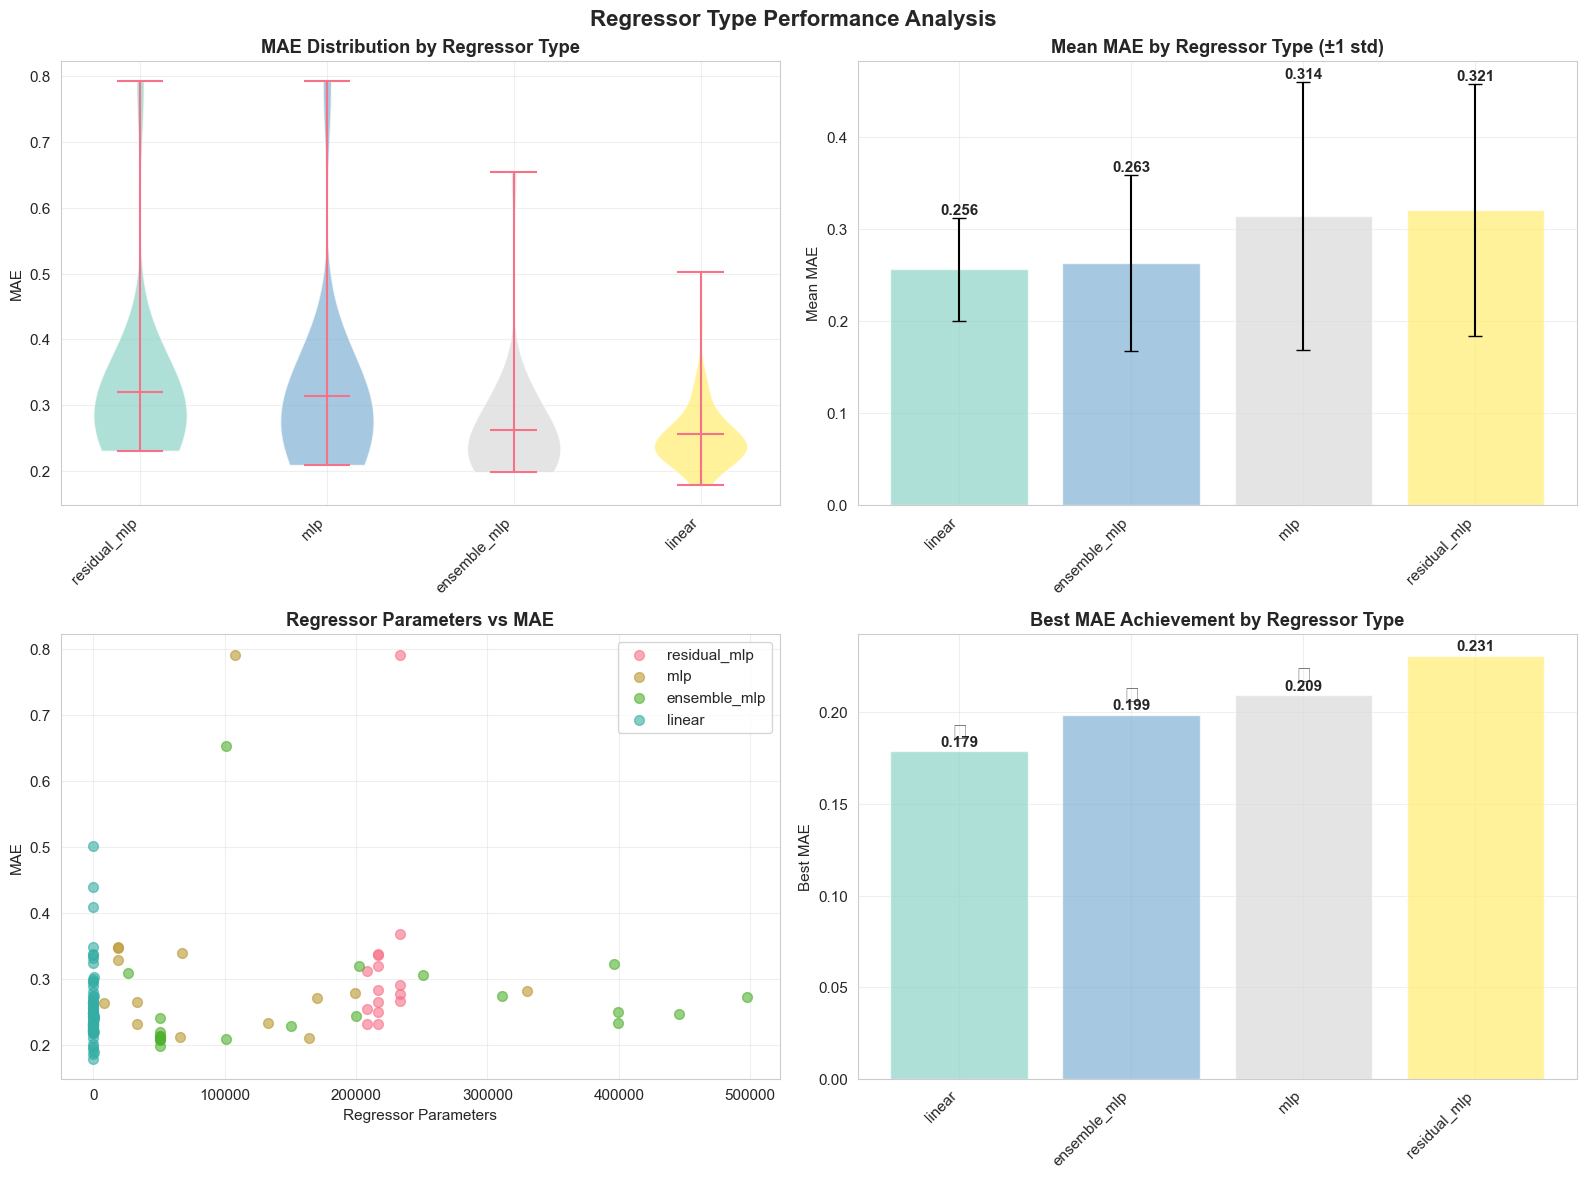


📊 Regressor type analysis plot saved to: Plots/DeepLearning/regressor_type_analysis.png


In [59]:
# Regressor Type Performance Analysis
print("=== REGRESSOR TYPE PERFORMANCE ANALYSIS ===")
print()

# Filter data for regressor analysis
df_regressor = df_clean.copy()

# Identify regressor types from the dataset
regressor_types = []
regressor_col = None
for col in df_regressor.columns:
    if 'regressor' in col.lower() and 'type' in col.lower():
        regressor_types = df_regressor[col].dropna().unique()
        regressor_col = col
        break

# If no direct regressor type column found, infer from column names
if len(regressor_types) == 0:
    # Look for regressor-related columns to infer types
    regressor_cols = [col for col in df_regressor.columns if 'regressor' in col.lower()]
    if regressor_cols:
        # Use the first regressor column that has categorical values
        for col in regressor_cols:
            unique_vals = df_regressor[col].dropna().unique()
            if len(unique_vals) < 10 and all(isinstance(val, str) for val in unique_vals if pd.notna(val)):
                regressor_types = unique_vals
                regressor_col = col
                break
    
    # If still no regressor types found, create synthetic ones based on available data
    if len(regressor_types) == 0:
        # Look for patterns in column names or create default categories
        potential_regressor_cols = [col for col in df_regressor.columns if any(keyword in col.lower() for keyword in ['linear', 'mlp', 'regression', 'dense'])]
        if potential_regressor_cols:
            # Create a synthetic regressor type based on the presence of specific parameters
            regressor_type_mapping = []
            for idx, row in df_regressor.iterrows():
                if any('linear' in str(val).lower() for val in row.values if pd.notna(val)):
                    regressor_type_mapping.append('Linear')
                elif any('mlp' in str(val).lower() for val in row.values if pd.notna(val)):
                    regressor_type_mapping.append('MLP')
                else:
                    regressor_type_mapping.append('Default')
            
            df_regressor['regressor_type'] = regressor_type_mapping
            regressor_col = 'regressor_type'
            regressor_types = df_regressor[regressor_col].unique()
        else:
            # Fallback: create simple categories based on parameter complexity
            param_cols = [col for col in df_regressor.columns if 'param' in col.lower()]
            if param_cols:
                # Simple vs Complex based on parameter count
                complexity_scores = []
                for idx, row in df_regressor.iterrows():
                    non_null_params = sum(1 for col in param_cols if pd.notna(row[col]))
                    complexity_scores.append(non_null_params)
                
                median_complexity = np.median(complexity_scores)
                regressor_type_mapping = ['Complex' if score > median_complexity else 'Simple' for score in complexity_scores]
                df_regressor['regressor_type'] = regressor_type_mapping
                regressor_col = 'regressor_type'
                regressor_types = df_regressor[regressor_col].unique()

# If we still don't have regressor types, create a single category
if len(regressor_types) == 0:
    df_regressor['regressor_type'] = 'Standard'
    regressor_col = 'regressor_type'
    regressor_types = ['Standard']

# Clean regressor types
regressor_types_clean = [rt for rt in regressor_types if pd.notna(rt)]
df_regressor = df_regressor[df_regressor[regressor_col].notna()]

print(f"Found {len(regressor_types_clean)} regressor types: {regressor_types_clean}")
print(f"Total trials with regressor data: {len(df_regressor)}")
print()

# Statistical analysis of regressor types
print("Statistical Analysis of Regressor Types:")
print("-" * 50)

regressor_stats = []
for regressor_type in regressor_types_clean:
    regressor_data = df_regressor[df_regressor[regressor_col] == regressor_type]
    if len(regressor_data) > 0:
        mae_values = regressor_data['val_mae'].dropna()
        if len(mae_values) > 0:
            stats = {
                'Regressor_Type': regressor_type,
                'Count': len(mae_values),
                'Mean_MAE': mae_values.mean(),
                'Std_MAE': mae_values.std(),
                'Min_MAE': mae_values.min(),
                'Max_MAE': mae_values.max(),
                'Median_MAE': mae_values.median(),
                'Q25_MAE': mae_values.quantile(0.25),
                'Q75_MAE': mae_values.quantile(0.75)
            }
            regressor_stats.append(stats)
            print(f"{regressor_type}: {len(mae_values)} trials, MAE = {mae_values.mean():.4f} ± {mae_values.std():.4f}")

regressor_stats = pd.DataFrame(regressor_stats)
regressor_stats = regressor_stats.sort_values('Mean_MAE')

print()
print("Regressor Type Ranking (by Mean MAE):")
print("-" * 40)
for i, (_, row) in enumerate(regressor_stats.iterrows()):
    rank_emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}."
    print(f"{rank_emoji} {row['Regressor_Type']}: {row['Mean_MAE']:.4f} ± {row['Std_MAE']:.4f}")

# Statistical significance test (Kruskal-Wallis)
if len(regressor_types_clean) > 1:
    regressor_groups = [df_regressor[df_regressor[regressor_col] == rt]['val_mae'].dropna() for rt in regressor_types_clean]
    regressor_groups = [group for group in regressor_groups if len(group) > 0]
    
    if len(regressor_groups) > 1:
        from scipy.stats import kruskal
        stat, p_value = kruskal(*regressor_groups)
        print(f"\nKruskal-Wallis Test: H = {stat:.4f}, p-value = {p_value:.6f}")
        if p_value < 0.05:
            print("✅ Significant difference between regressor types (p < 0.05)")
        else:
            print("❌ No significant difference between regressor types (p ≥ 0.05)")

print()

# Find best performing configuration for each regressor type
best_by_regressor = []
for regressor_type in regressor_types_clean:
    regressor_data = df_regressor[df_regressor[regressor_col] == regressor_type]
    if len(regressor_data) > 0:
        best_trial = regressor_data.loc[regressor_data['val_mae'].idxmin()]
        best_by_regressor.append({
            'Regressor_Type': regressor_type,
            'Best_MAE': best_trial['val_mae'],
            'Trial_Number': best_trial['trial_number']
        })

best_by_regressor = pd.DataFrame(best_by_regressor)
best_by_regressor = best_by_regressor.sort_values('Best_MAE')

print("Best Performance by Regressor Type:")
print("-" * 40)
for i, (_, row) in enumerate(best_by_regressor.iterrows()):
    rank_emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}."
    print(f"{rank_emoji} {row['Regressor_Type']}: {row['Best_MAE']:.4f} (Trial #{row['Trial_Number']})")

# Overall best regressor type
best_regressor_type = best_by_regressor.iloc[0]['Regressor_Type']
best_overall_mae = best_by_regressor.iloc[0]['Best_MAE']
print(f"\n🏆 Overall Best Regressor Type: {best_regressor_type} (MAE: {best_overall_mae:.4f})")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Regressor Type Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Violin plot of MAE distribution by regressor type
ax1 = axes[0, 0]
regressor_data_list = []
regressor_labels = []
for regressor_type in regressor_types_clean:
    data = df_regressor[df_regressor[regressor_col] == regressor_type]['val_mae'].dropna()
    if len(data) > 0:
        regressor_data_list.append(data)
        regressor_labels.append(regressor_type)

if regressor_data_list:
    parts = ax1.violinplot(regressor_data_list, positions=range(len(regressor_labels)), showmeans=True)
    ax1.set_xticks(range(len(regressor_labels)))
    ax1.set_xticklabels(regressor_labels, rotation=45, ha='right')
    ax1.set_ylabel('MAE')
    ax1.set_title('MAE Distribution by Regressor Type', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Color the violin plots
    colors = plt.cm.Set3(np.linspace(0, 1, len(parts['bodies'])))
    for patch, color in zip(parts['bodies'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

# Plot 2: Bar plot of mean MAE with error bars
ax2 = axes[0, 1]
means = regressor_stats['Mean_MAE'].values
stds = regressor_stats['Std_MAE'].values
labels = regressor_stats['Regressor_Type'].values

bars = ax2.bar(range(len(labels)), means, yerr=stds, capsize=5, alpha=0.7, 
               color=plt.cm.Set3(np.linspace(0, 1, len(labels))))
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Mean MAE')
ax2.set_title('Mean MAE by Regressor Type (±1 std)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.001,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Scatter plot of regressor parameters vs MAE (if regressor-specific params exist)
ax3 = axes[1, 0]
regressor_param_cols = [col for col in df_regressor.columns if 'regressor' in col.lower() and col != regressor_col]

if regressor_param_cols:
    # Use the first numerical regressor parameter
    param_col = None
    for col in regressor_param_cols:
        if df_regressor[col].dtype in ['int64', 'float64']:
            param_col = col
            break
    
    if param_col:
        for i, regressor_type in enumerate(regressor_types_clean):
            type_data = df_regressor[df_regressor[regressor_col] == regressor_type]
            if len(type_data) > 0:
                x = type_data[param_col].dropna()
                y = type_data.loc[x.index, 'val_mae']
                ax3.scatter(x, y, alpha=0.6, label=regressor_type, s=50)
        
        ax3.set_xlabel(param_col.replace('_', ' ').title())
        ax3.set_ylabel('MAE')
        ax3.set_title('Regressor Parameters vs MAE', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No numerical regressor\nparameters found', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Regressor Parameters vs MAE', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'No regressor-specific\nparameters found', 
            ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Regressor Parameters vs MAE', fontweight='bold')

# Plot 4: Bar plot of best MAE per regressor type
ax4 = axes[1, 1]
best_maes = best_by_regressor['Best_MAE'].values
best_labels = best_by_regressor['Regressor_Type'].values

bars = ax4.bar(range(len(best_labels)), best_maes, alpha=0.7, 
               color=plt.cm.Set3(np.linspace(0, 1, len(best_labels))))
ax4.set_xticks(range(len(best_labels)))
ax4.set_xticklabels(best_labels, rotation=45, ha='right')
ax4.set_ylabel('Best MAE')
ax4.set_title('Best MAE Achievement by Regressor Type', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mae in zip(bars, best_maes):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{mae:.3f}', ha='center', va='bottom', fontweight='bold')

# Add ranking indicators
for i, bar in enumerate(bars):
    rank_emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else ""
    if rank_emoji:
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                rank_emoji, ha='center', va='bottom', fontsize=16)

plt.tight_layout()
plt.savefig(r'c:\Polimi\Master\2Sem\ACA_GraphML_Project\Notebooks\Plots\DeepLearning\regressor_type_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Regressor type analysis plot saved to: Plots/DeepLearning/regressor_type_analysis.png")